### 0. Imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

import skforecast
from skforecast.sarimax import Sarimax as sk_sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error

from statsmodels.tsa.statespace.sarimax import SARIMAX

import sys
sys.path.append("..")

import src.soporte_sarima as ss

import warnings
warnings.filterwarnings("once")

c:\Users\Miguel\.virtualenvs\9._Clustering_-_Regresión-T2F1V_og\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
global_superstore = pd.read_pickle("../data/clusters/global_superstore_clusters.pkl")
global_superstore.head(2)

row_id        order_id order_date  ship_date     ship_mode customer_id  \
0  32298  CA-2012-124891 2012-07-31 2012-07-31      Same Day    RH-19495   
1  26341   IN-2013-77878 2013-02-05 2013-02-05  Second Class    JR-16210   

   customer_name    segment market product_id    category sub-category  \
0    Rick Hansen   Consumer     US       PR-0  Technology  Accessories   
1  Justin Ritter  Corporate   APAC       PR-1   Furniture       Chairs   

                                        product_name     sales quantity  \
0  Plantronics CS510 - Over-the-Head monaural Wir...  2309.650        7   
1          Novimex Executive Leather Armchair, Black  3709.395        9   

   discount    profit  shipping_cost order_priority customer_cluster  
0       0.0  762.1845         933.57       Critical                0  
1       0.1 -288.7650         923.63       Critical                1

# 1. Introduction

The purpose of this notebook is to perform time series forecasting to predict:
1. The next few months revenue, and
2. The demand for several essential items, identified as top priority through the prior notebook's data analysis.

# 2. Forecasting

## 2.1 Next cycle revenue forecasting

Forecasted revenue can be an important information for the operational planning of the company, which can give overview of what the company can expect to receive in order to also plan costs.

### 2.1.1 Generate revenue ('sales') time series

Get the sales amounts and order date.

In [44]:
global_superstore_revenue = global_superstore[["order_date","sales"]]
global_superstore_revenue.head(2)

order_date     sales
0 2012-07-31  2309.650
1 2013-02-05  3709.395

Resample to monthly data by aggregating quantity sums per month.

In [45]:
# Resample to monthly
global_superstore_revenue_resampled = (global_superstore_revenue
                                                .set_index("order_date")[["sales"]]
                                                .resample("MS").sum()).reset_index()

# Generate month and year columns
global_superstore_revenue_resampled["year"] = global_superstore_revenue_resampled["order_date"].dt.year
global_superstore_revenue_resampled["month"] = global_superstore_revenue_resampled["order_date"].dt.month_name()
global_superstore_revenue_resampled.head(5)

order_date         sales  year     month
0 2011-01-01   98898.48886  2011   January
1 2011-02-01   91152.15698  2011  February
2 2011-03-01  145729.36736  2011     March
3 2011-04-01  116915.76418  2011     April
4 2011-05-01  146747.83610  2011       May

### 2.1.2 Time series analysis

Let's start by checking for missing values, duplicates and ranges.

In [47]:
ts_analizer = ss.TimeSeriesAnalysis(global_superstore_revenue_resampled, temporal_column="order_date",value_column="sales")

ts_analizer.exploracion_datos()

El número de filas es 48 y el número de columnas es 3

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


count           mean            std          min           25%  \
sales   48.0  263385.456456  113883.490073  91152.15698  175175.90023   
year    48.0    2012.500000       1.129865   2011.00000    2011.75000   

                50%           75%         max  
sales  254557.77431  328348.02567  555279.027  
year     2012.50000    2013.25000    2014.000

Ensure there are no time gaps in the time series 'quantity' measure.

In [48]:
ts_analizer.comprobar_serie_continua(frecuencia="MS",periodo="M")

La serie temporal es continua, no faltan meses.


Plot the whole time series.

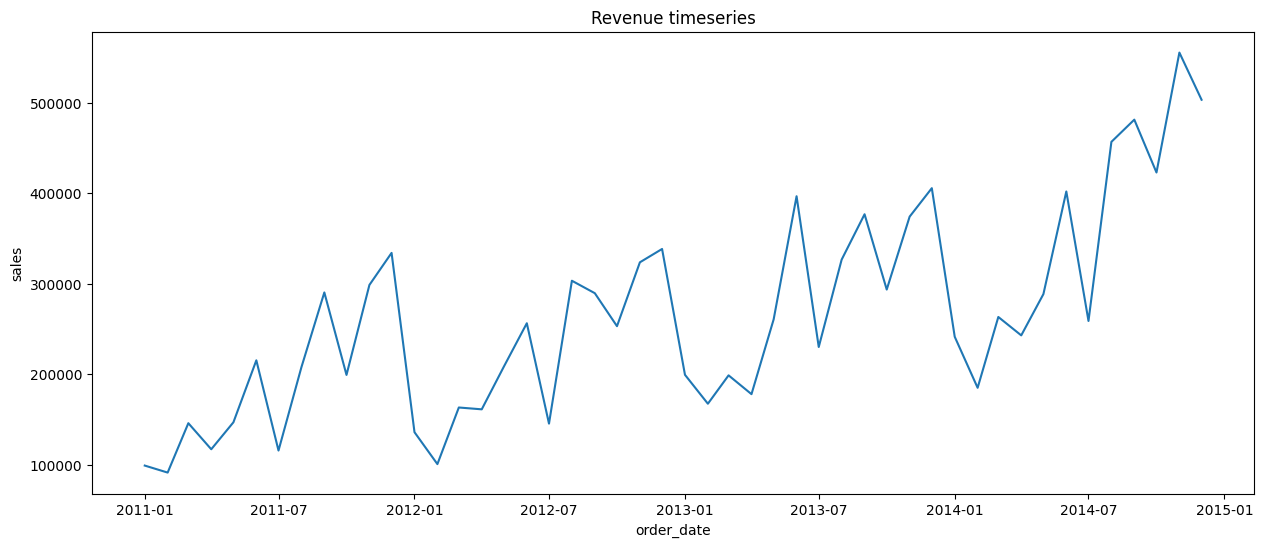

In [49]:
plt.figure(figsize=(15,6))
plt.title("Revenue timeseries")
sns.lineplot(data=ts_analizer.data,
             x="order_date",
             y="sales")
plt.show()

Judging from just the timeseries, there is a very obvious upward trend. Some seasonal spikes and valleys are observed, in what look like a fairly yearly seasonal pattern underneath the trend. 

Let's plot the year time series, hued by year.

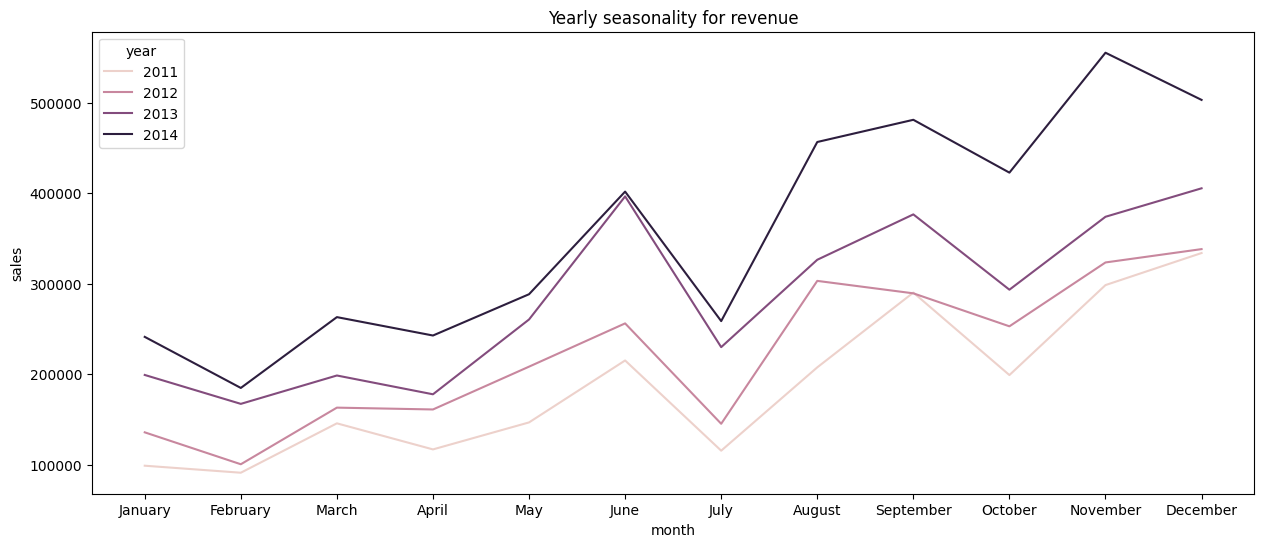

In [50]:
plt.figure(figsize=(15,6))
plt.title("Yearly seasonality for revenue")
sns.lineplot(data=ts_analizer.data,
             x="month",
             y="sales",
             hue="year")
plt.show()

With different magnitude jumpgs, it is clear that there are clear yearly patterns of seasonality. For example, sales decrease slightly in February and progressively increase up to June, to thereafter plummet in July and then again in October. However, the overall upward trend is maintained throughout the year.

Knowing there is actually a yearly seasonal pattern, let's decompose the time series to observe trend, seasonality and noise.

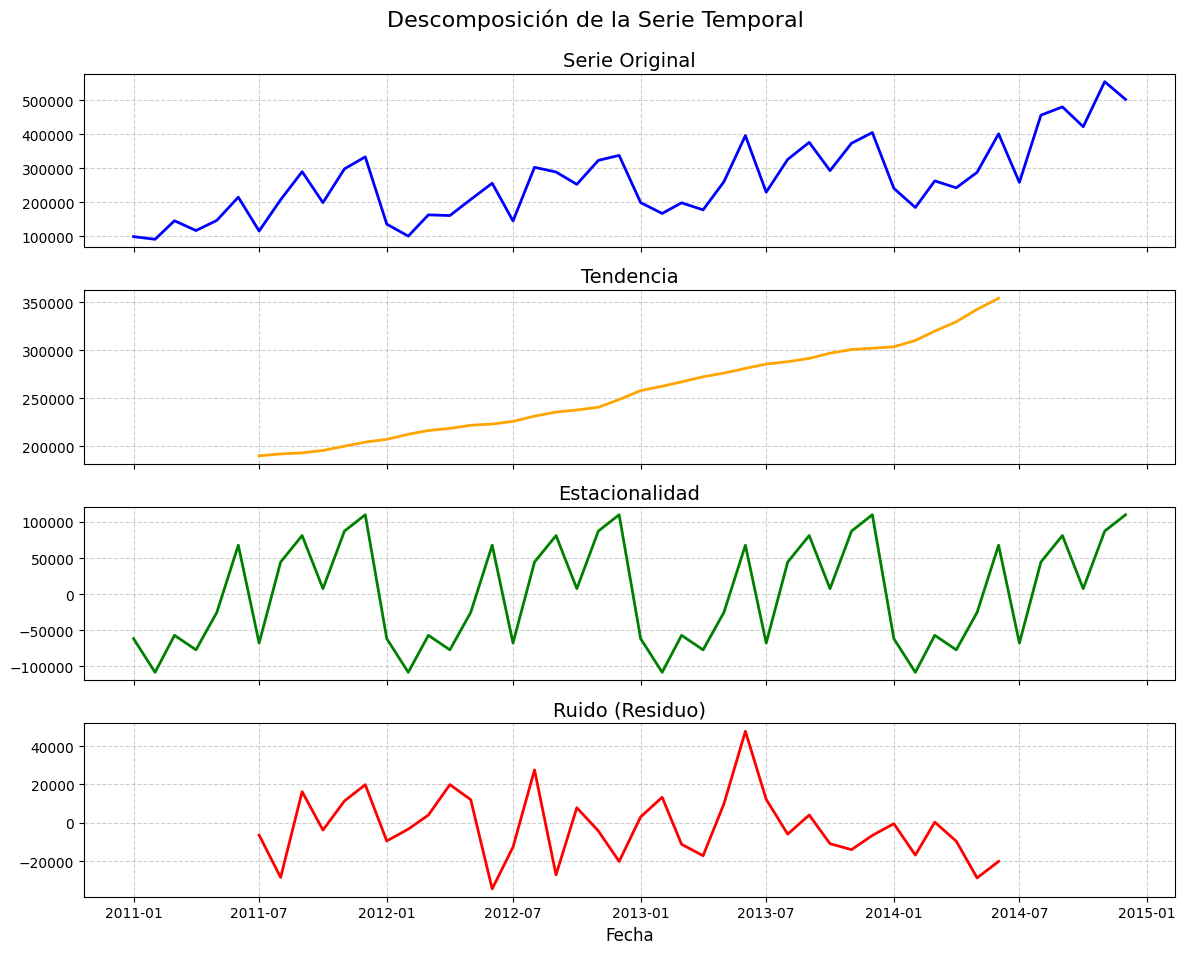

In [51]:
ts_analizer.detectar_estacionalidad()

The biggest actor is the trend, with seasonality playing a major role too that accounts for almost 50% of the variability at the beginning of the trend. Noise has a big effect, which means that we either accept it or include exogenous features to possibly extract its hidden information.

### 2.1.3 Choose SARIMA parameters

The chosen model to tackle this time series forecasting is a Sarima model. This model takes in the necessary parameters p,d,q. d stands for differentiation and to choose it, it is necessary to apply a differentiation to the time series until it becomes stationary.

In [53]:
ts_analizer.prueba_estacionariedad(ts_analizer.data[["sales"]])

data_test_diff_1 = ts_analizer.data[["sales"]].diff().dropna()
ts_analizer.prueba_estacionariedad(data_test_diff_1)

Test estacionariedad
-------------------------------------
ADF Statistic: 0.618332151767819, p-value: 0.9880588762240523
Test estacionariedad
-------------------------------------
ADF Statistic: -8.601760741885261, p-value: 6.838862147916916e-14


Data is considered stationary after 1 differentiation, thus ***d*** should be equalt to 1. Plotting the differentiated time series:

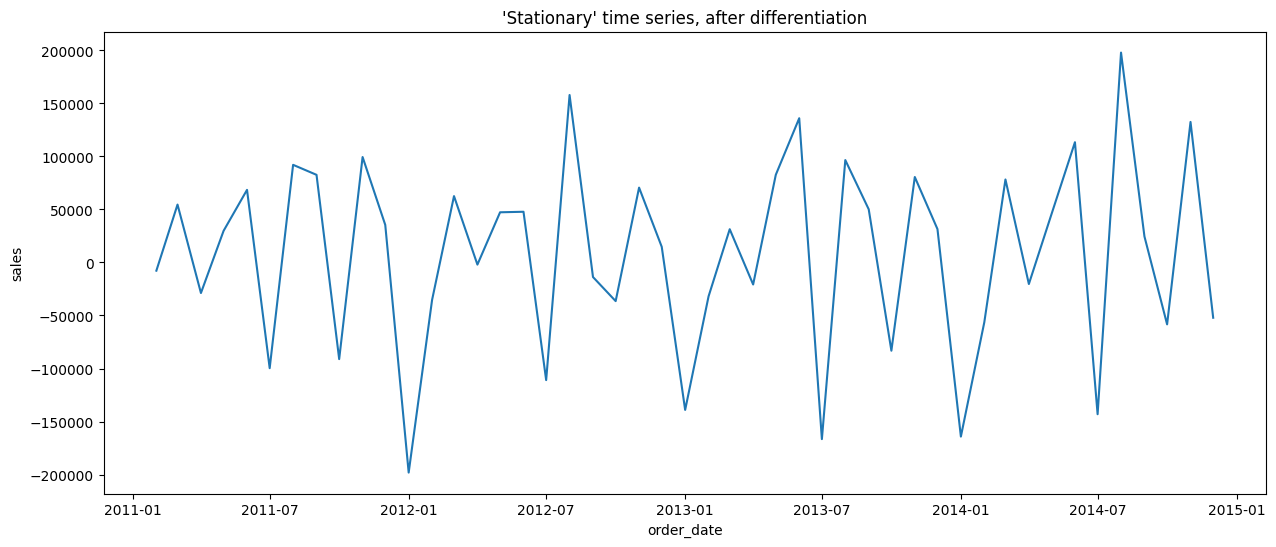

In [55]:
plt.figure(figsize=(15,6))
plt.title("'Stationary' time series, after differentiation")
sns.lineplot(data=data_test_diff_1,
             x="order_date",
             y="sales")
plt.show()

The new revenue time series looks stationary, meaning that it shows no obvious trend and variance is equal across the timeframe.

To choose the other two parameters, ***q*** and ***p***, we need to analyse the ACF and PACF plots, respectively, of the differentiated timeseries. However, it is important to first plot both plots for the original time series to observe patterns.

<Figure size 1200x1000 with 0 Axes>

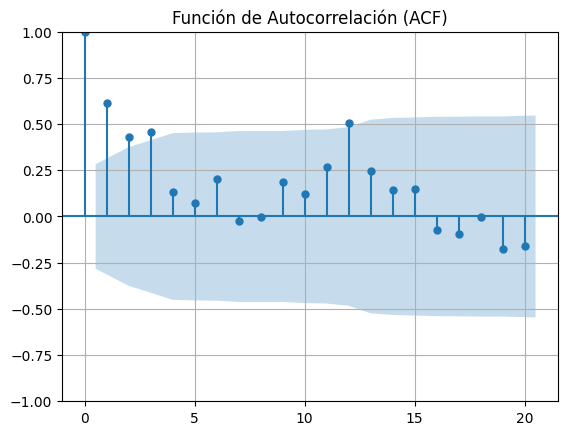

<Figure size 1200x1000 with 0 Axes>

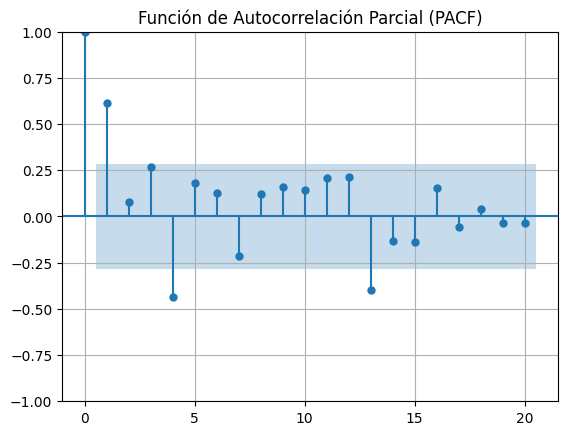

In [57]:
ts_analizer.graficar_acf_pacf(data_test=ts_analizer.data[["sales"]], lags=20)

In the original ACF, we observe that the autocorrleations fall quickly into the non-significance zone, which means there is not a very strong autocorrelation with past values. There is also a damped sinusoidal yearly wave that almost completely stays within the no-significance zone, which points to a yearly seasonal effect.

Analysing the differentiated ACF and PACF:

<Figure size 1200x1000 with 0 Axes>

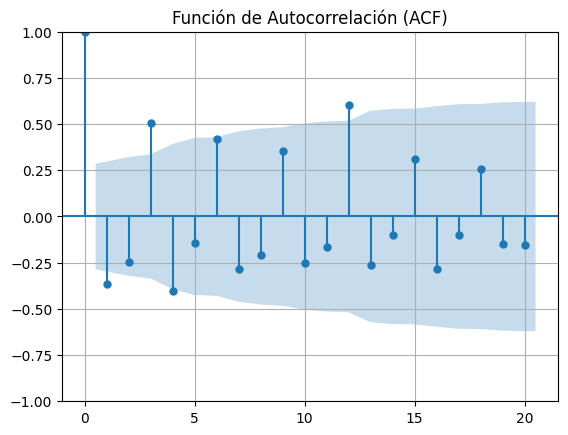

<Figure size 1200x1000 with 0 Axes>

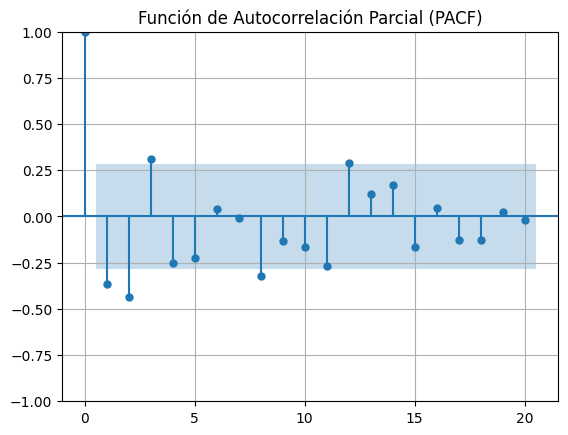

In [58]:
ts_analizer.graficar_acf_pacf(data_test=data_test_diff_1.dropna(), lags=20)

The ACF falls into the no-significance zone after 1 lag, which points to a ***q*** equal to 1. Meanwhile, the PACF falls within no-significance after 2 lags, which points to a ***p*** equal to 2.

Sarima has variations of these 3 parameters (***P***,***D***,***Q***), plus another one that marks the seasonal cycle ***m*** or ***s***. Given that there is a seasonal cycle of 12 periods (a year), ***m*** should equal 12. Then, to uncover the other 3 parameters, an additional differentiation to the differentiated time series should be applied, however, the time series is already stationary and additional differentiations at the seasonal cycle level are not needed. 

The hypothesis test and plot is performed, nevertheless, for contrasting purposes.

Test estacionariedad
-------------------------------------
ADF Statistic: -7.121683153064489, p-value: 3.7084674734742075e-10


<Figure size 1200x1000 with 0 Axes>

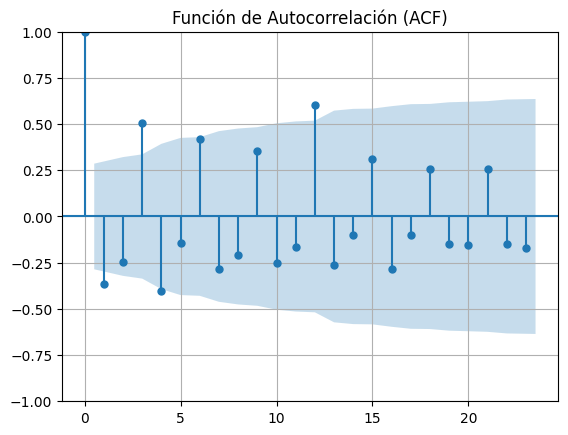

<Figure size 1200x1000 with 0 Axes>

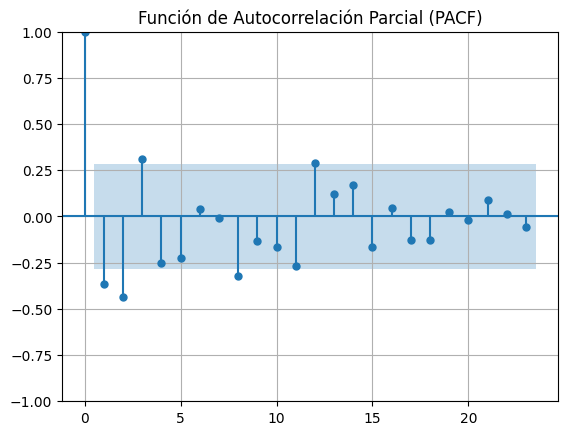

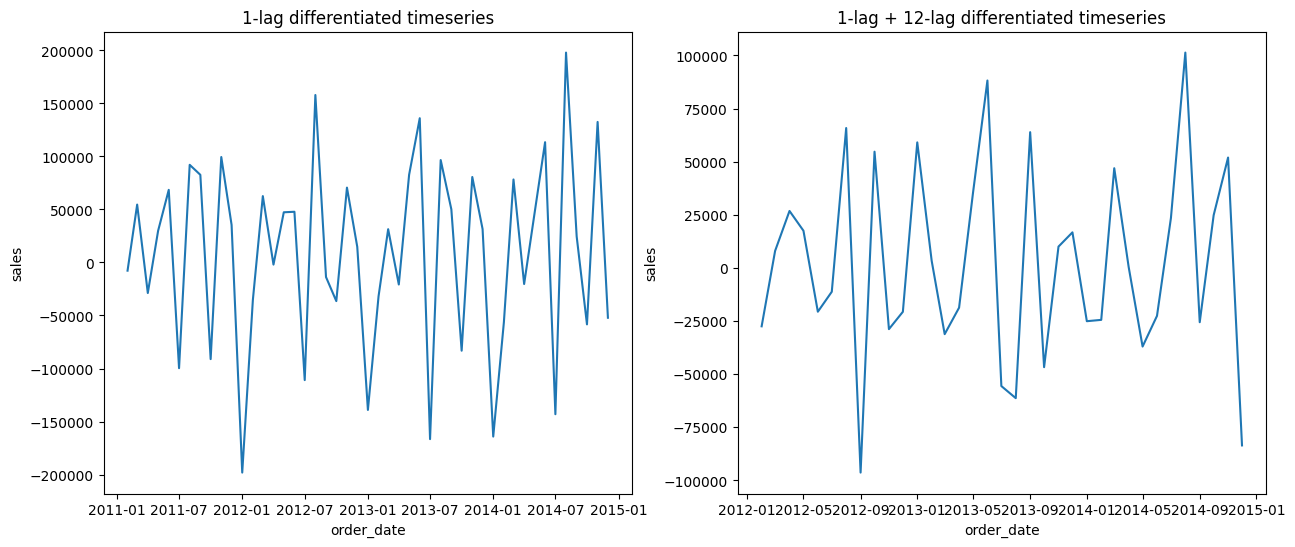

In [75]:
# differentiate the stationarized time series by 12 lags.
data_test_diff_1_12 = data_test_diff_1.diff(12).dropna()

# perform stationary hypothesis test
ts_analizer.prueba_estacionariedad(data_test_diff_1_12)

# plot ACF and PACF
ts_analizer.graficar_acf_pacf(data_test=data_test_diff_1, lags=23)


# Plot both time series
fig, axes = plt.subplots(1,2,figsize=(15,6))

axes[0].set_title("1-lag differentiated timeseries")
sns.lineplot(
    data=data_test_diff_1,
    x="order_date",
    y="sales",
    ax=axes[0]
)

axes[1].set_title("1-lag + 12-lag differentiated timeseries")
sns.lineplot(
    data=data_test_diff_1_12,
    x="order_date",
    y="sales",
    ax=axes[1]
)

plt.show()


The ACF, inspected for lags at the seasonal level (12,24), shows a significant lag at 12, therefore ***Q*** = 1 lags. The PACF very dimly shows significance at ***P***=1 lags too. Nevertheless, a 'Grid Search' of parameters will be performed to validate the least error-prone model configuration.

100%|██████████| 405/405 [00:19<00:00, 20.79it/s]


Mejor modelo encontrado: 0 1 (1, 0, 2, 12)


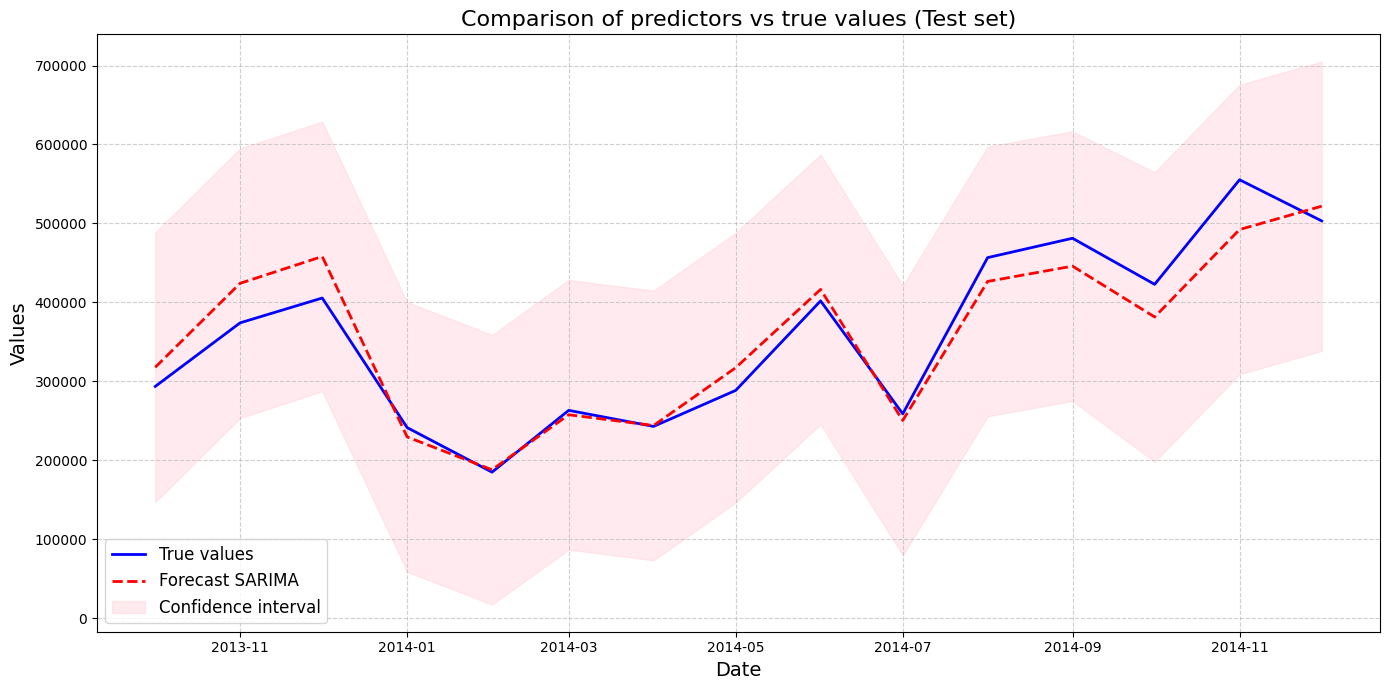

In [64]:
# Setting the target variable and performing train-test split
y = ts_analizer.data[["sales"]].astype("float").asfreq('MS')
train_size = int(0.7 * len(y))
y_train, y_test = y[:train_size], y[train_size:]

# setting the parameter combinations for the parameter grid search
p_range = range(0,5)
q_range = range(0,3)
seasonal_order_ranges = (range(0,3),range(0,3),range(0,3),[12])

# train and evaluate parameter combinations
warnings.filterwarnings("ignore") # filter out warnings
modelador = ss.SARIMAModel()
parametros = modelador.generar_parametros(p_range, q_range, seasonal_order_ranges)
resultados = modelador.evaluar_modelos_par(y_train, y_test, parametros, 1, len(y), "sales")
warnings.filterwarnings("default") # bring back warnings

Plotting the test predictions now in context with the train set:

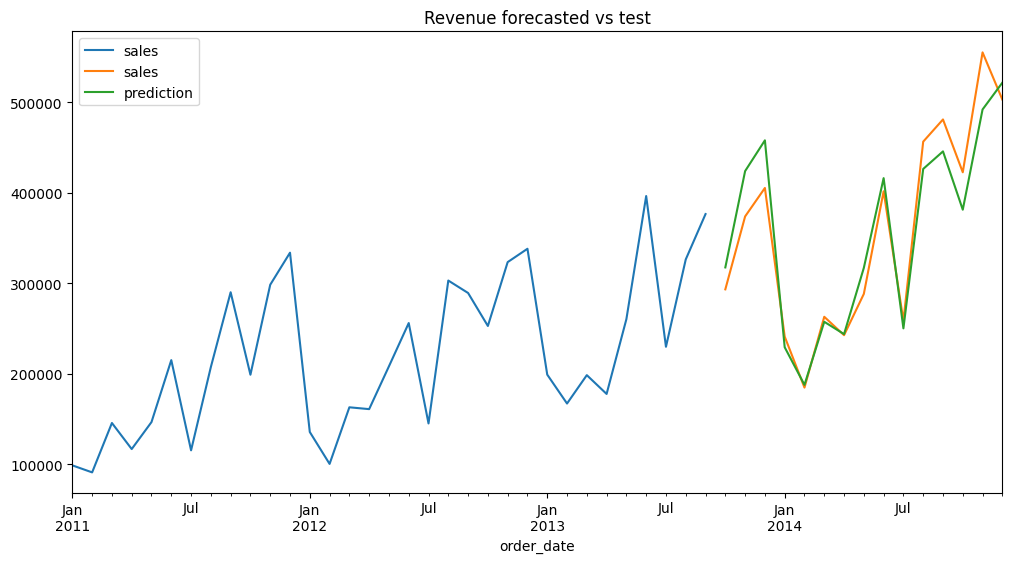

p  q seasonal_order          RMSE
38  0  1  (1, 0, 2, 12)  31988.214184
73  0  2  (2, 0, 1, 12)  32087.032428
91  1  0  (1, 0, 1, 12)  32446.672247

In [63]:
y_pred_test = pd.Series(modelador.best_model["pred_test"], index=y_test.index)

# plot
fig, ax=plt.subplots(figsize=(12, 6))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred_test.plot(ax=ax, label='prediction')
ax.set_title('Revenue forecasted vs test')
ax.legend()
plt.show()

# display top 3 parameter settings:

resultados[["p","q","seasonal_order","RMSE"]].sort_values(by="RMSE").head(3)

The best model is different to that explored previously, showing ***p***=0 and ***q***=1 in contrast to the explored ***p***=2 and ***q***=1. On the other hand, ***P*** and ***Q*** show similar values to what was found in the analysis, ignoring the fact that a second AR lag could not be found with the ACF as it did not allow to plot lags beyond 23. 

Given that the model has found this configuration to be the one yielding the least RMSE, it will be used for future Binders demand forecasting.

### 2.1.4 Revenue forecasting

Now, it is time to provide the forecast for Binder subcategory demand.

In [76]:
best_model_params = modelador.best_model

modelo_sarima_full = SARIMAX(
    y,
    order=(0, 1, 1),
    seasonal_order=(1,0,2,12),
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

# Forecast 12 months ahead
forecast_start = len(y)
forecast_end = forecast_start + 11
forecast_dates = pd.date_range(
    start=y.index[-1] + pd.offsets.DateOffset(months=1),
    periods=12,
    freq='MS'
)
forecast = modelo_sarima_full.predict(start=forecast_start, end=forecast_end)
forecast = pd.Series(forecast.values, index=forecast_dates)

c:\Users\Miguel\.virtualenvs\9._Clustering_-_Regresión-T2F1V_og\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Plotting the demand forecasted for the upcoming 12 months:

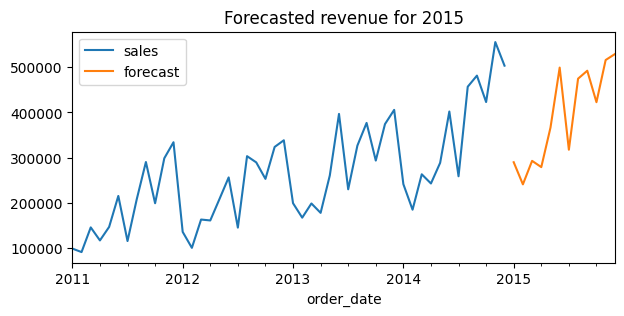

In [77]:
fig, ax=plt.subplots(figsize=(7, 3))
y.plot(ax=ax, label='time series')
forecast.plot(ax=ax, label='forecast')
ax.set_title('Forecasted revenue for 2015')
ax.legend()
plt.show()

### 2.1.5 Comments about the revenue forecast for 2015

The forecast for the upcoming months of revenue does not completely try to follow the last years AR pattern, and instead is focusing on both last and previous year, correcting for the explosive growth in revenue last year showed.

The provided forecast tries to give an approximated view of what the demand will be for a set of products in the upcoming year. However, as new data is received from the past months demand, it is recommended to refit the model to obtain more accurate short-term forecasts.

## 2.2 Forecasting demand - binders

Binders have been identified as one of the essential items our top cluster of customers buys the most. Albeit not profitable by itself, being one of their most recurrent items, the company should guarantee continuous supply to allow for cross or up selling of more profitable items like smartphones or copiers, etc.

The approach to this forecast is to forecast total demand for all customers. That way, in case of underforecasting we can always prioritize our top customers to provide their supply.

### 2.2.1 Generate binder quantity time series

Filter by Binder sub-category.

In [3]:
global_superstore_binders = global_superstore[global_superstore["sub-category"]=="Binders"]
global_superstore_binders.head(2)

row_id        order_id order_date  ship_date       ship_mode customer_id  \
8   40155  CA-2014-135909 2014-10-14 2014-10-14  Standard Class    JW-15220   
45  35395  CA-2011-116904 2011-09-23 2011-09-23  Standard Class    SC-10095   

   customer_name    segment market product_id         category sub-category  \
8      Jane Waco  Corporate     US       PR-8  Office Supplies      Binders   
45  Sanjit Chand   Consumer     US      PR-41  Office Supplies      Binders   

                                         product_name    sales quantity  \
8   Fellowes PB500 Electric Punch Plastic Comb Bin...  5083.96        5   
45               Ibico EPK-21 Electric Binding System  9449.95        5   

    discount     profit  shipping_cost order_priority customer_cluster  
8        0.2  1906.4850         867.69            Low                3  
45       0.0  4630.4755         655.61         Medium                0

Resample to monthly data by aggregating quantity sums per month.

In [4]:
# Resample to monthly
global_superstore_binders_resampled = (global_superstore_binders
                                                .set_index("order_date")[["quantity"]]
                                                .resample("MS").sum()).reset_index()

# Generate month and year columns
global_superstore_binders_resampled["year"] = global_superstore_binders_resampled["order_date"].dt.year
global_superstore_binders_resampled["month"] = global_superstore_binders_resampled["order_date"].dt.month_name()
global_superstore_binders_resampled.head(5)

order_date quantity  year     month
0 2011-01-01      176  2011   January
1 2011-02-01      152  2011  February
2 2011-03-01      211  2011     March
3 2011-04-01      253  2011     April
4 2011-05-01      224  2011       May

### 2.2.2 Time series analysis

Let's start by checking for missing values, duplicates and ranges.

In [5]:
ts_analizer = ss.TimeSeriesAnalysis(global_superstore_binders_resampled, temporal_column="order_date",value_column="quantity")

ts_analizer.exploracion_datos()

El número de filas es 48 y el número de columnas es 3

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


count    mean       std     min      25%     50%      75%     max
year   48.0  2012.5  1.129865  2011.0  2011.75  2012.5  2013.25  2014.0

Ensure there are no time gaps in the time series 'quantity' measure.

In [6]:
ts_analizer.comprobar_serie_continua(frecuencia="MS",periodo="M")

La serie temporal es continua, no faltan meses.


Plot the whole time series.

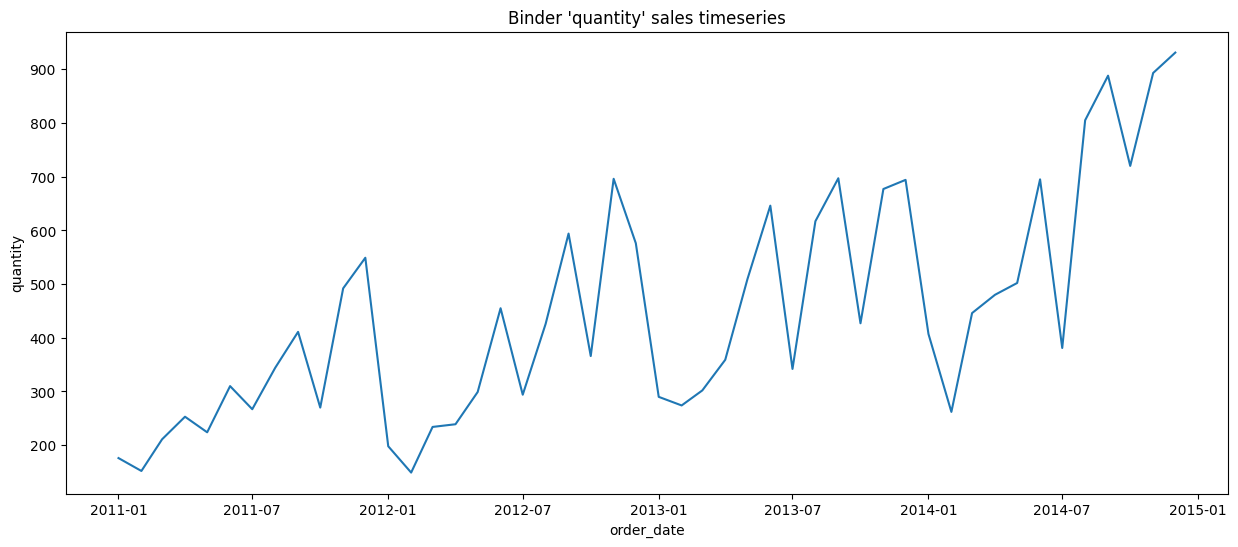

In [7]:
plt.figure(figsize=(15,6))
plt.title("Binder 'quantity' sales timeseries")
sns.lineplot(data=ts_analizer.data,
             x="order_date",
             y="quantity")
plt.show()

Judging from just the timeseries, there is a very obvious upward trend. Some seasonal spikes and valleys are observed, in what look like a fairly yearly seasonal pattern underneath the trend. 

Let's plot the year time series, hued by year.

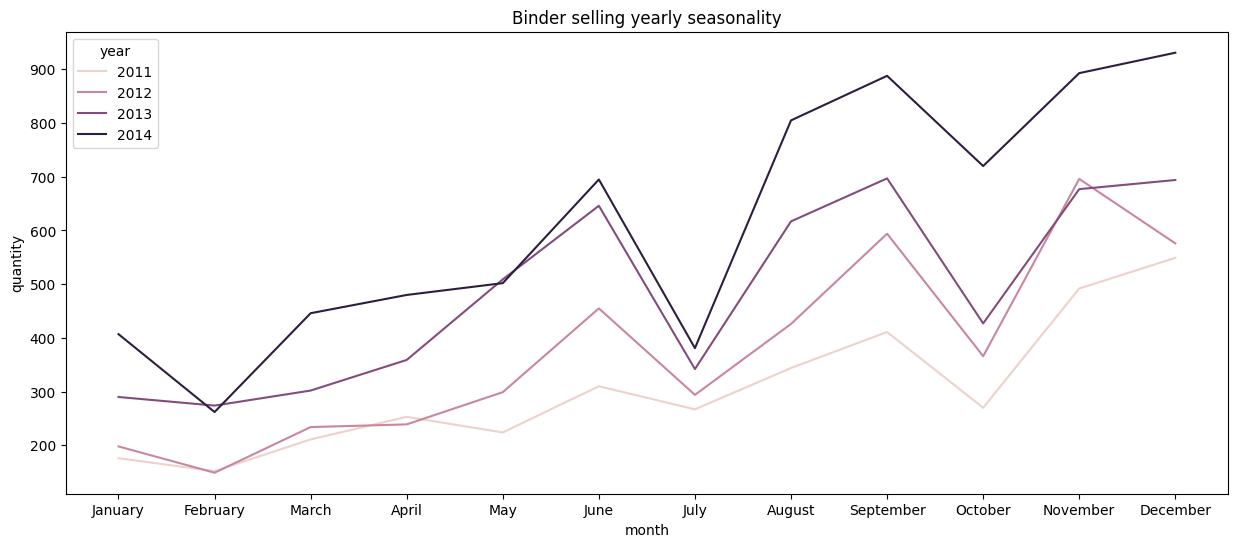

In [8]:
plt.figure(figsize=(15,6))
plt.title("Binder selling yearly seasonality")
sns.lineplot(data=ts_analizer.data,
             x="month",
             y="quantity",
             hue="year")
plt.show()

Although magnitudes differ, there are clear yearly patterns of seasonality. For example, quantities sold decrease slightly in February and progressively increase up to June, to thereafter plummet in July and then again in October. However, the overall upward trend is maintained throughout the year.

Knowing there is actually a yearly seasonal pattern, let's decompose the time series to observe trend, seasonality and noise.

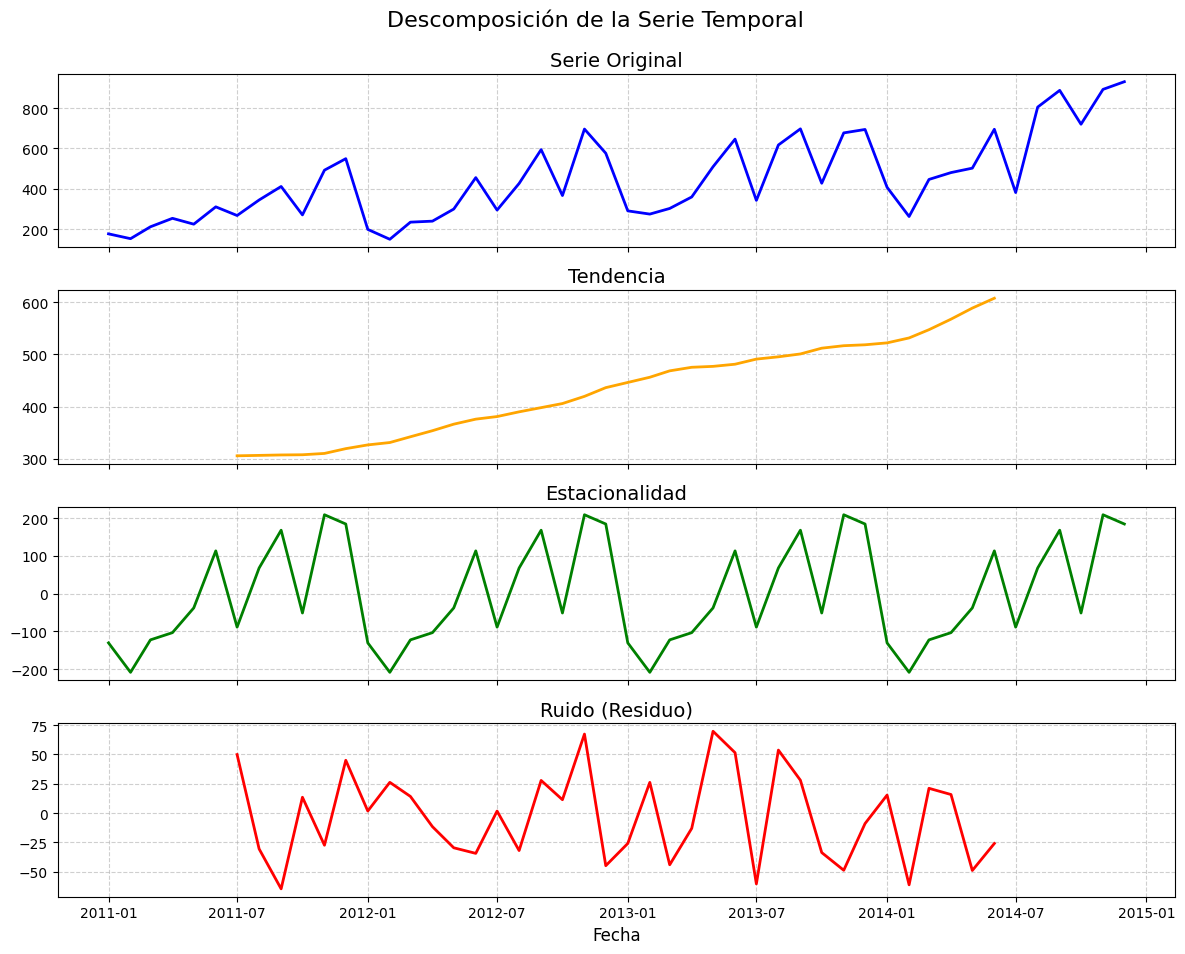

In [9]:
ts_analizer.detectar_estacionalidad()

The biggest actor is the trend, with seasonality playing a major relative impact at the beginning of the time series. Noise has a big effect, which means that we either accept it or include exogenous features to possibly extract its hidden information.

### 2.2.3 Choose SARIMA parameters

The chosen model to tackle this time series forecasting is a Sarima model. This model takes in the necessary parameters p,d,q. d stands for differentiation and to choose it, it is necessary to apply a differentiation to the time series until it becomes stationary.

In [10]:
ts_analizer.prueba_estacionariedad(ts_analizer.data[["quantity"]])

data_test_diff_1 = ts_analizer.data[["quantity"]].diff().dropna()
ts_analizer.prueba_estacionariedad(data_test_diff_1)

Test estacionariedad
-------------------------------------
ADF Statistic: 0.8294198566067615, p-value: 0.9920965193111464
Test estacionariedad
-------------------------------------
ADF Statistic: -7.12871745320976, p-value: 3.5637906083427437e-10


Data is considered stationary after 1 differentiation, thus ***d*** should be equalt to 1. Plotting the differentiated time series:

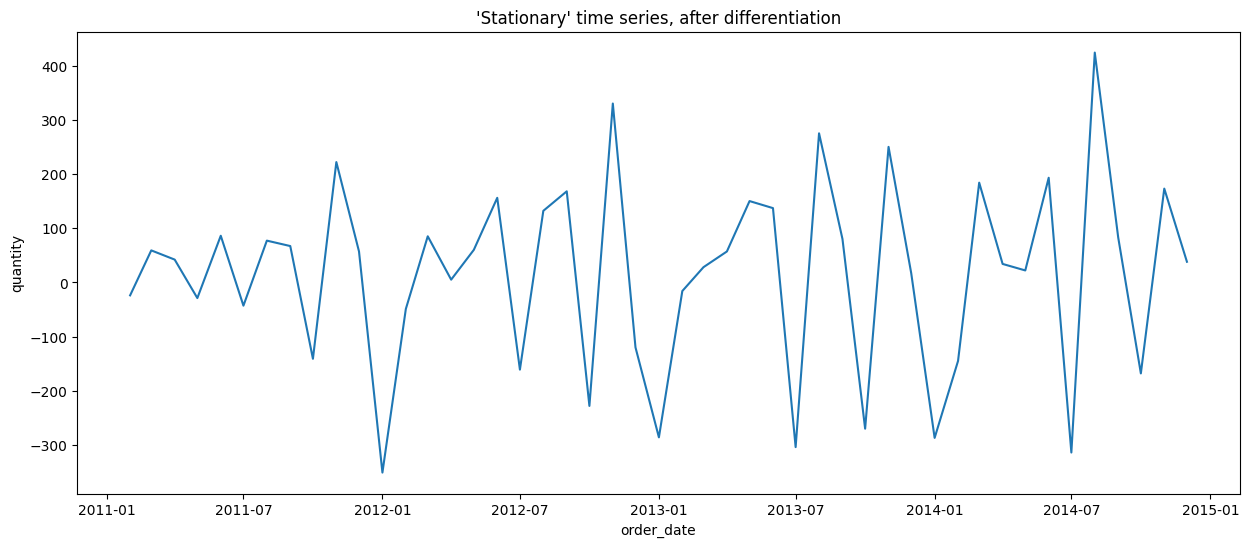

In [11]:
plt.figure(figsize=(15,6))
plt.title("'Stationary' time series, after differentiation")
sns.lineplot(data=data_test_diff_1,
             x="order_date",
             y="quantity")
plt.show()

To choose the other two parameters, ***q*** and ***p***, we need to analyse the ACF and PACF plots, respectively, of the differentiated timeseries. However, it is important to first plot both plots for the original time series to observe patterns.

<Figure size 1200x1000 with 0 Axes>

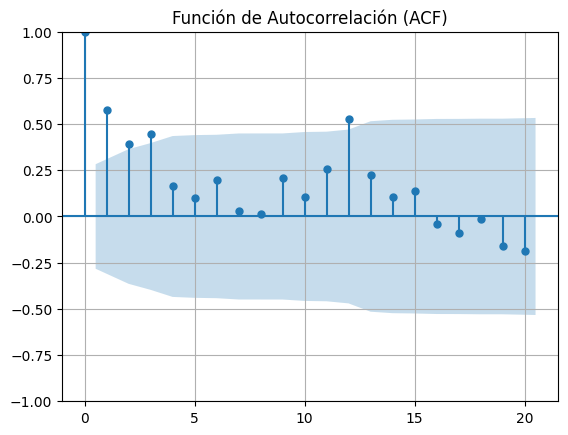

<Figure size 1200x1000 with 0 Axes>

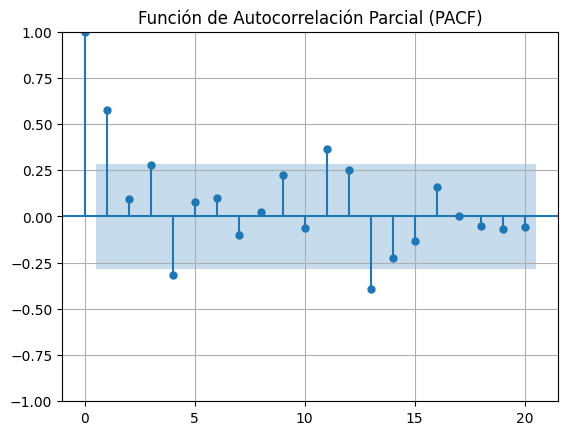

In [12]:
ts_analizer.graficar_acf_pacf(data_test=ts_analizer.data[["quantity"]], lags=20)

In the original ACF, we observe that the autocorrleations fall quickly into the non-significance zone, which means there is not a very strong autocorrelation with past values. There is also a damped sinusoidal yearly wave that almost completely stays within the no-significance zone, which points to a yearly seasonal effect.

Analysing the differentiated ACF and PACF:

<Figure size 1200x1000 with 0 Axes>

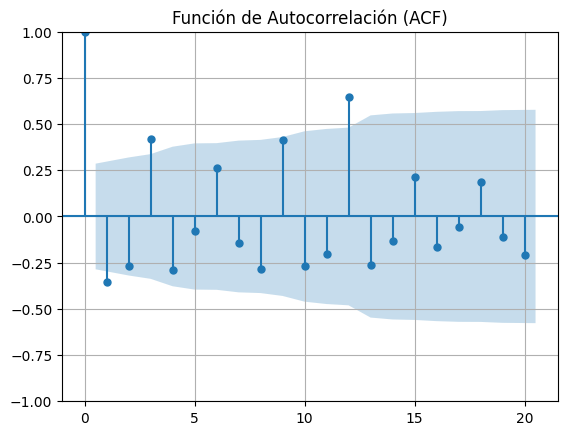

<Figure size 1200x1000 with 0 Axes>

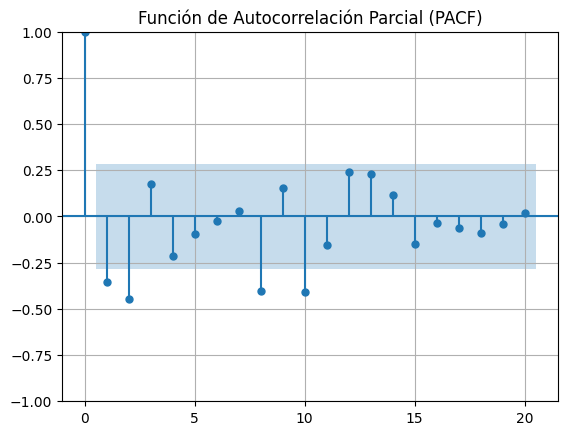

In [13]:
ts_analizer.graficar_acf_pacf(data_test=data_test_diff_1.dropna(), lags=20)

The ACF falls into the no-significance zone after 1 lag, which points to a ***q*** equal to 1. Meanwhile, the PACF falls within no-significance after 2 lags, which points to a ***p*** equal to 2.

Sarima has variations of these 3 parameters (***P***,***D***,***Q***), plus another one that marks the seasonal cycle ***m*** or ***s***. Given that there is a seasonal cycle of 12 periods (a year), ***m*** should equal 12. Then, to uncover the other 3 parameters, an additional differentiation to the differentiated time series must be applied, to once more inspect the ACF and PACF to count the number of lags before insignificance.

Test estacionariedad
-------------------------------------
ADF Statistic: -6.790285173946503, p-value: 2.374267848429148e-09


<Figure size 1200x1000 with 0 Axes>

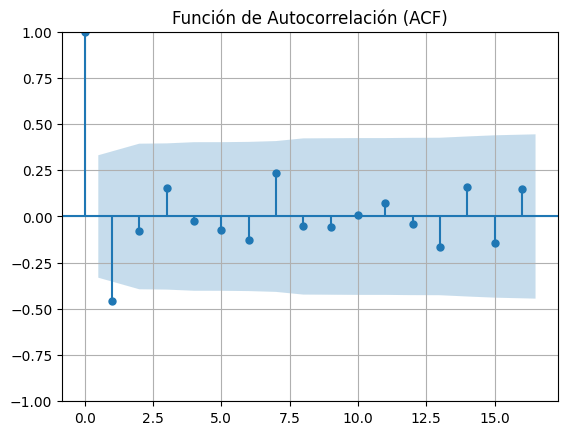

<Figure size 1200x1000 with 0 Axes>

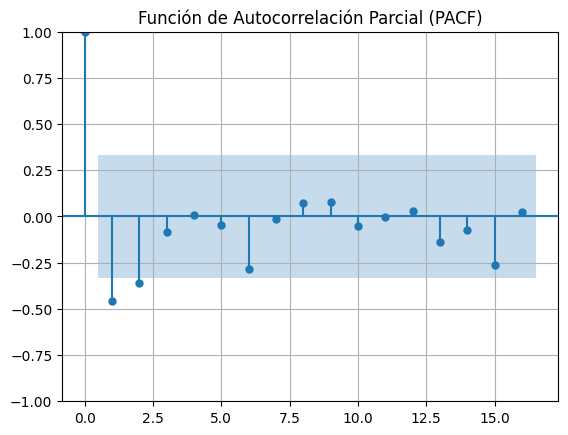

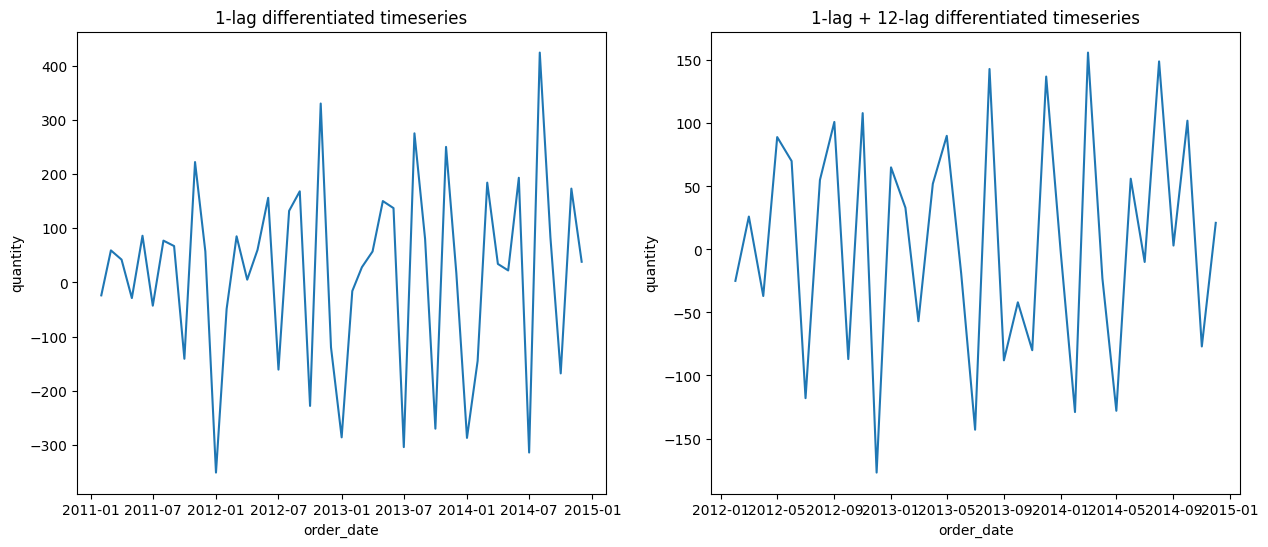

In [14]:
# differentiate the stationarized time series by 12 lags.
data_test_diff_1_12 = data_test_diff_1.diff(12).dropna()

# perform stationary hypothesis test
ts_analizer.prueba_estacionariedad(data_test_diff_1_12)

# plot ACF and PACF
ts_analizer.graficar_acf_pacf(data_test=data_test_diff_1_12, lags=16)


# Plot both time series
fig, axes = plt.subplots(1,2,figsize=(15,6))

axes[0].set_title("1-lag differentiated timeseries")
sns.lineplot(
    data=data_test_diff_1,
    x="order_date",
    y="quantity",
    ax=axes[0]
)

axes[1].set_title("1-lag + 12-lag differentiated timeseries")
sns.lineplot(
    data=data_test_diff_1_12,
    x="order_date",
    y="quantity",
    ax=axes[1]
)

plt.show()


The time series differentiated once more, by 12 lags now, displays statistical evidence to affirm that it is stationary. The ACF falls out of significance at ***Q*** 1 lags. The ACF falls out of significance at ***P*** 2 lags. Nevertheless, a 'Grid Search' of parameters will be performed to validate the least error-prone model configuration.

  0%|          | 0/405 [00:00<?, ?it/s]

100%|██████████| 405/405 [00:49<00:00,  8.17it/s]


Mejor modelo encontrado: 4 2 (1, 0, 1, 12)


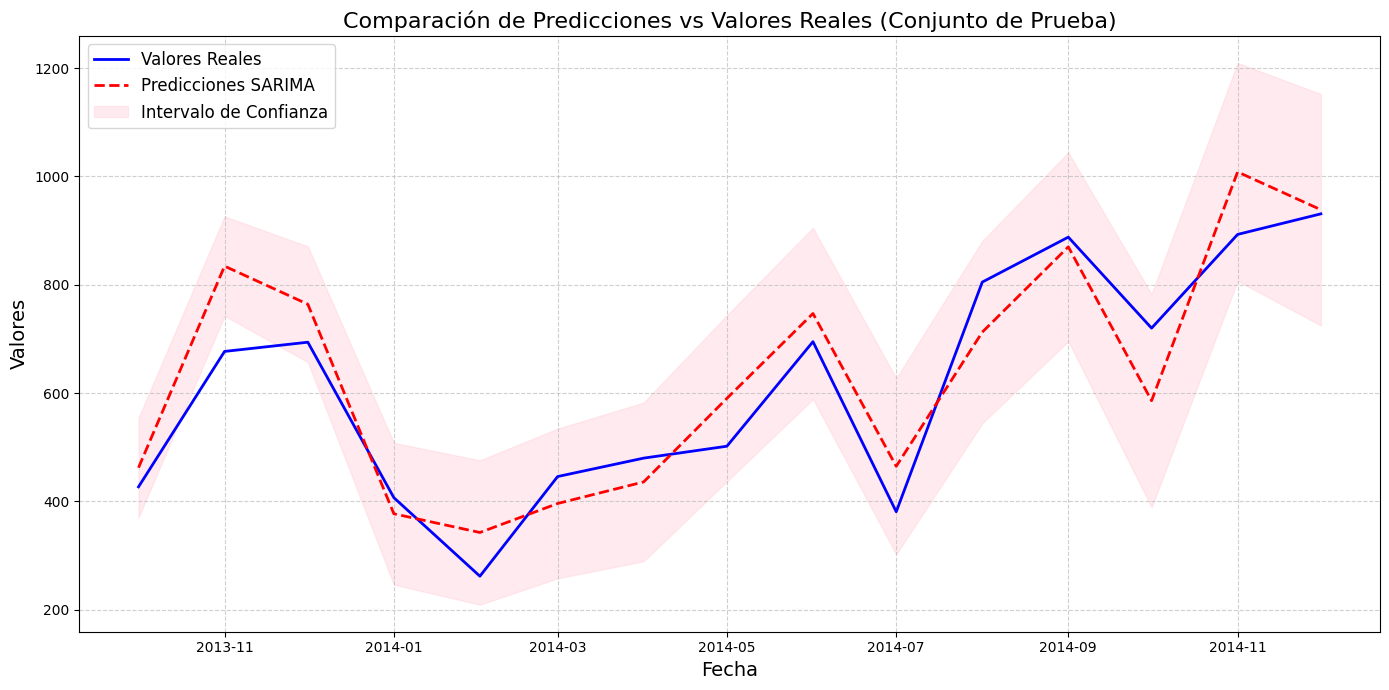

In [15]:
# Setting the target variable and performing train-test split
y = ts_analizer.data[["quantity"]].astype("float").asfreq('MS')
train_size = int(0.7 * len(y))
y_train, y_test = y[:train_size], y[train_size:]

# setting the parameter combinations for the parameter grid search
p_range = range(0,5)
q_range = range(0,3)
seasonal_order_ranges = (range(0,3),range(0,3),range(0,3),[12])

# train and evaluate parameter combinations
warnings.filterwarnings("ignore") # filter out warnings
modelador = ss.SARIMAModel()
parametros = modelador.generar_parametros(p_range, q_range, seasonal_order_ranges)
resultados = modelador.evaluar_modelos_par(y_train, y_test, parametros, 1, len(y), "quantity")
warnings.filterwarnings("default") # bring back warnings

Plotting the test predictions now in context with the train set:

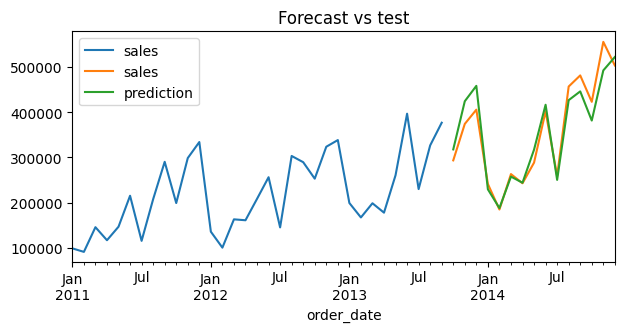

p  q seasonal_order          RMSE
38  0  1  (1, 0, 2, 12)  31988.214184
73  0  2  (2, 0, 1, 12)  32087.032428
91  1  0  (1, 0, 1, 12)  32446.672247

In [ ]:
y_pred_test = pd.Series(modelador.best_model["pred_test"], index=y_test.index)

# plot
fig, ax=plt.subplots(figsize=(7, 3))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred_test.plot(ax=ax, label='prediction')
ax.set_title('Quantity forecast vs true values (test)')
ax.legend()
plt.show()

# display top 3 parameter settings:

resultados[["p","q","seasonal_order","RMSE"]].sort_values(by="RMSE").head(3)

The best model is different to that explored previously. However, given that it is the one yielding the least RMSE, it will be used for future Binders demand forecasting.

### 2.2.4 Binder forecasting

Now, it is time to provide the forecast for Binder subcategory demand.

In [38]:
best_model_params = modelador.best_model

modelo_sarima_full = SARIMAX(
    y,
    order=(4, 1, 2),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

# Forecast 12 months ahead
forecast_start = len(y)
forecast_end = forecast_start + 11
forecast_dates = pd.date_range(
    start=y.index[-1] + pd.offsets.DateOffset(months=1),
    periods=12,
    freq='MS'
)
forecast = modelo_sarima_full.predict(start=forecast_start, end=forecast_end)
forecast = pd.Series(forecast.values, index=forecast_dates)

c:\Users\Miguel\.virtualenvs\9._Clustering_-_Regresión-T2F1V_og\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Miguel\.virtualenvs\9._Clustering_-_Regresión-T2F1V_og\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Plotting the demand forecasted for the upcoming 12 months:

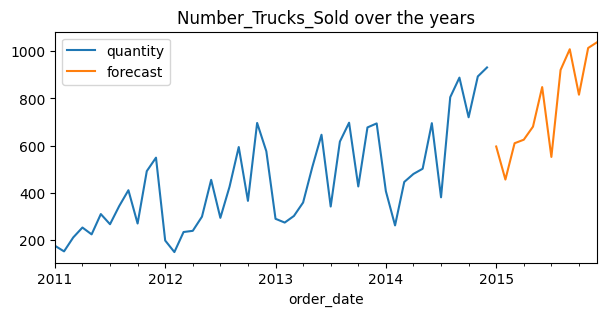

In [ ]:
fig, ax=plt.subplots(figsize=(7, 3))
y.plot(ax=ax, label='time series')
forecast.plot(ax=ax, label='forecast')
ax.set_title('Forecasted demand of Binders for 2015')
ax.legend()
plt.show()

### 2.2.5 Comments about the forecast

The provided forecast tries to give an approximated view of what the demand will be for a set of products in the upcoming year. However, as new data is received from the past months demand, it is recommended to refit the model to obtain more accurate short-term forecasts.

## 2.3 Forecasting demand - storage

### 2.3.1 Generate storage quantity time series

Filter by Storage sub-category.

In [86]:
global_superstore_storage = global_superstore[global_superstore["sub-category"]=="Storage"]
global_superstore_storage.head(2)

row_id        order_id order_date  ship_date       ship_mode customer_id  \
117  38362  CA-2011-106726 2011-12-06 2011-12-06     First Class    RS-19765   
197  34367  CA-2011-119375 2011-11-17 2011-11-17  Standard Class    YC-11895   

      customer_name    segment market product_id         category  \
117  Roland Schwarz  Corporate     US      PR-91  Office Supplies   
197  Yoseph Carroll  Corporate     US     PR-140  Office Supplies   

    sub-category                                       product_name    sales  \
117      Storage                   Standard Rollaway File with Lock  1261.33   
197      Storage  Smead Adjustable Mobile File Trolley with Lock...  2934.33   

    quantity  discount    profit  shipping_cost order_priority  \
117        7       0.0  327.9458         506.49       Critical   
197        7       0.0  792.2691         428.80           High   

    customer_cluster  
117                2  
197                2

Resample to monthly data by aggregating quantity sums per month.

In [87]:
# Resample to monthly
global_superstore_storage_resampled = (global_superstore_storage
                                                .set_index("order_date")[["quantity"]]
                                                .resample("MS").sum()).reset_index()

# Generate month and year columns
global_superstore_storage_resampled["year"] = global_superstore_storage_resampled["order_date"].dt.year
global_superstore_storage_resampled["month"] = global_superstore_storage_resampled["order_date"].dt.month_name()
global_superstore_storage_resampled.head(5)

order_date quantity  year     month
0 2011-01-01      167  2011   January
1 2011-02-01       92  2011  February
2 2011-03-01      178  2011     March
3 2011-04-01      195  2011     April
4 2011-05-01      198  2011       May

### 2.3.2 Time series analysis

Let's start by checking for missing values, duplicates and ranges.

In [88]:
ts_analizer = ss.TimeSeriesAnalysis(global_superstore_storage_resampled, temporal_column="order_date",value_column="quantity")

ts_analizer.exploracion_datos()

El número de filas es 48 y el número de columnas es 3

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


count    mean       std     min      25%     50%      75%     max
year   48.0  2012.5  1.129865  2011.0  2011.75  2012.5  2013.25  2014.0

Ensure there are no time gaps in the time series 'quantity' measure.

In [89]:
ts_analizer.comprobar_serie_continua(frecuencia="MS",periodo="M")

La serie temporal es continua, no faltan meses.


Plot the whole time series.

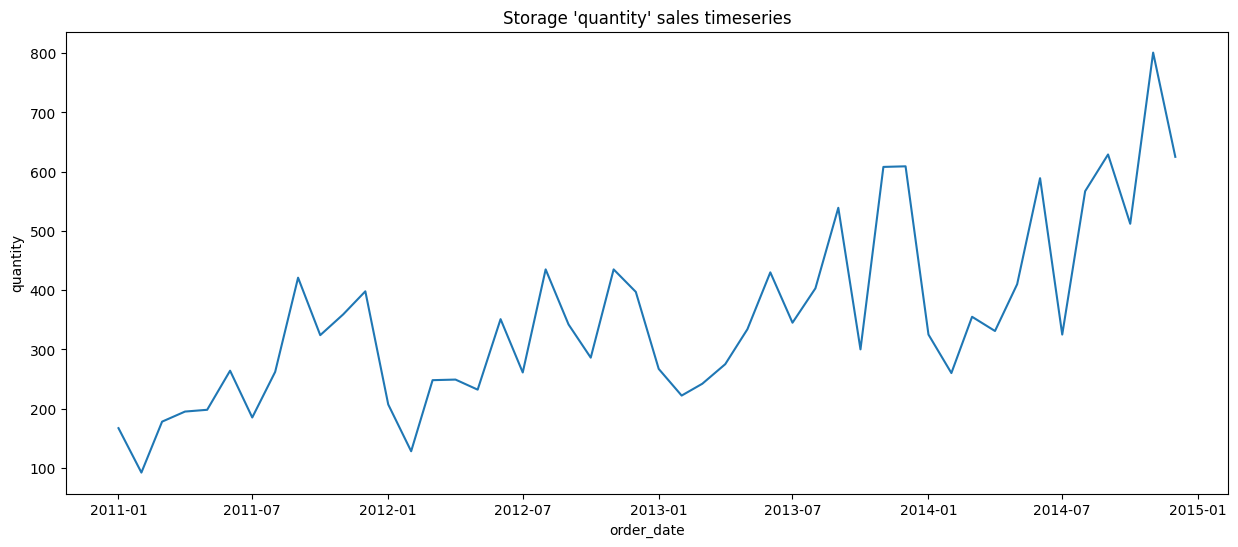

In [90]:
plt.figure(figsize=(15,6))
plt.title("Storage 'quantity' sales timeseries")
sns.lineplot(data=ts_analizer.data,
             x="order_date",
             y="quantity")
plt.show()

Judging from just the timeseries, there is a very obvious upward trend. Some seasonal spikes and valleys are observed, in what look like a fairly yearly seasonal pattern underneath the trend. 

Let's plot the year time series, hued by year.

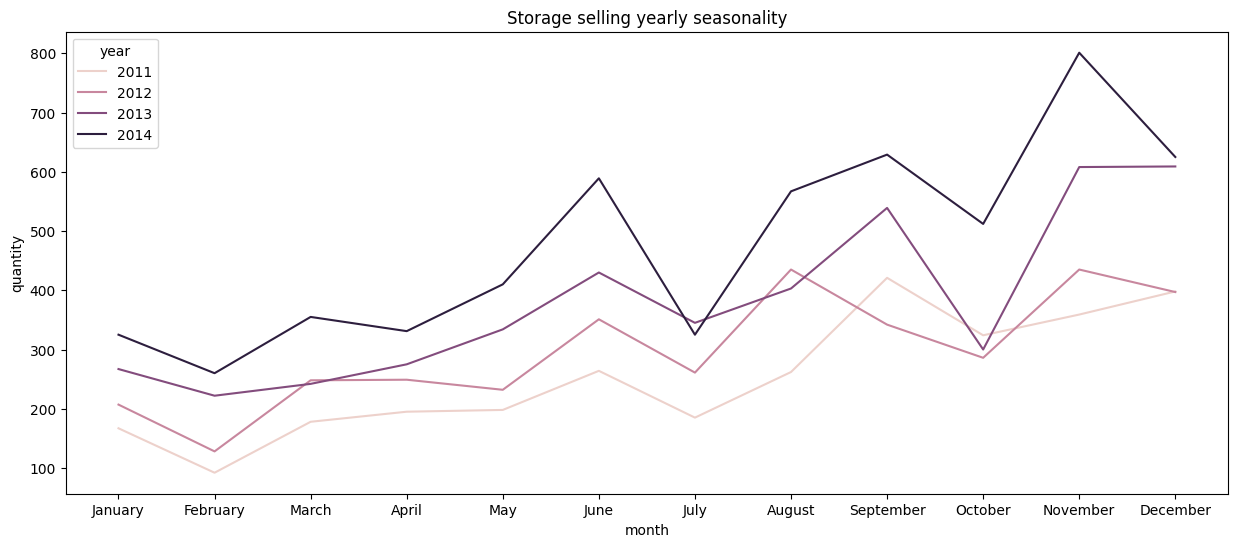

In [91]:
plt.figure(figsize=(15,6))
plt.title("Storage selling yearly seasonality")
sns.lineplot(data=ts_analizer.data,
             x="month",
             y="quantity",
             hue="year")
plt.show()

Although magnitudes differ, there are clear yearly patterns of seasonality. For example, quantities sold decrease slightly in February and progressively increase up to June, to thereafter plummet in July and then again in October. However, the overall upward trend is maintained throughout the year.

In 2014, a more dramatic decrease than previous years is observed in July and less dramatic than 2013 in Obtober.

Knowing there is actually a yearly seasonal pattern, let's decompose the time series to observe trend, seasonality and noise.

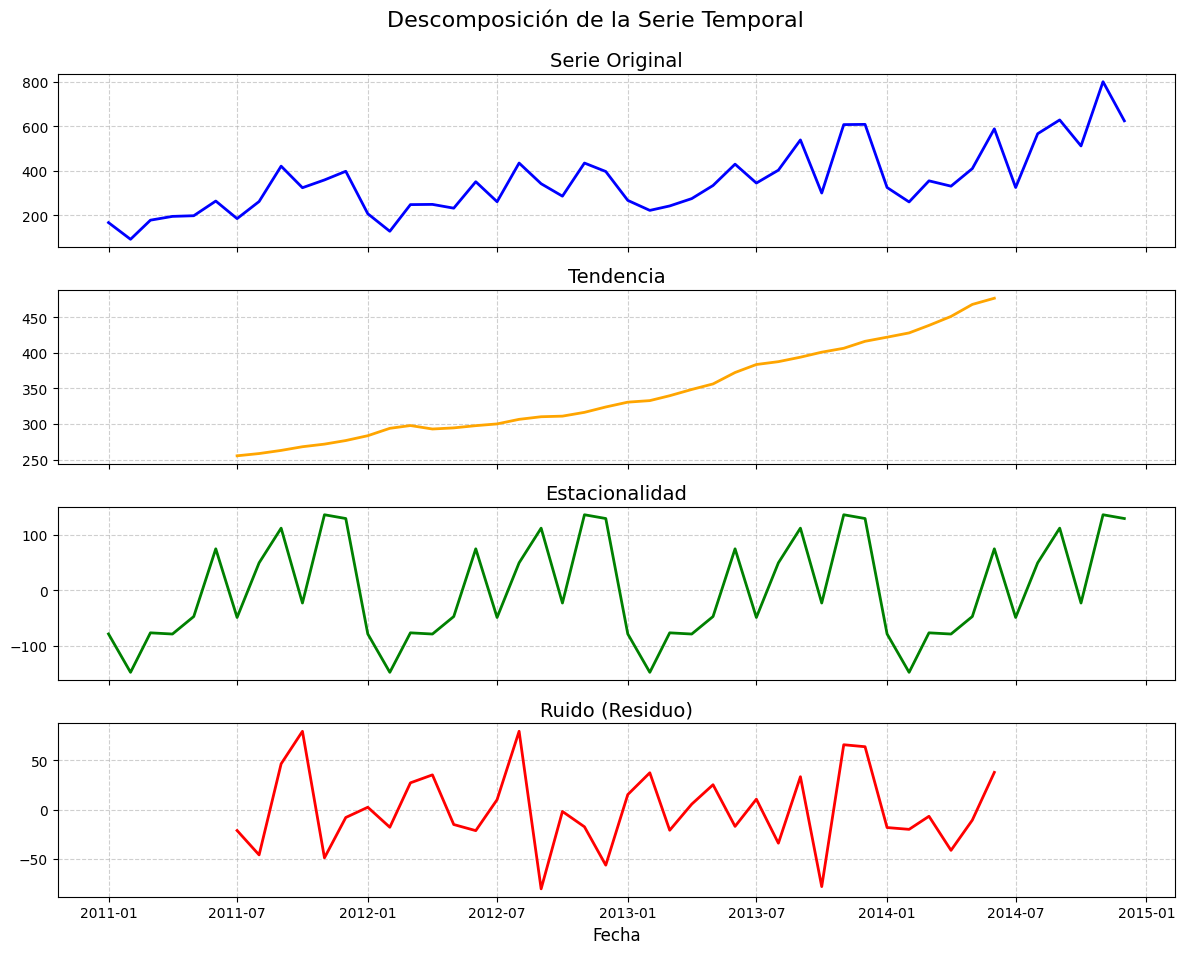

In [92]:
ts_analizer.detectar_estacionalidad()

The biggest actor is the trend, with seasonality playing a major relative impact at the beginning of the time series. Noise has a big effect, which means that we either accept it or include exogenous features to possibly extract its hidden information.

### 2.3.3 Choose SARIMA parameters

The chosen model to tackle this time series forecasting is a Sarima model. This model takes in the necessary parameters p,d,q. d stands for differentiation and to choose it, it is necessary to apply a differentiation to the time series until it becomes stationary.

In [93]:
ts_analizer.prueba_estacionariedad(ts_analizer.data[["quantity"]])

data_test_diff_1 = ts_analizer.data[["quantity"]].diff().dropna()
ts_analizer.prueba_estacionariedad(data_test_diff_1)

Test estacionariedad
-------------------------------------
ADF Statistic: 0.6765694260473246, p-value: 0.9893584837096605
Test estacionariedad
-------------------------------------
ADF Statistic: -6.95148531023311, p-value: 9.667220873650194e-10


Data is considered stationary after 1 differentiation, thus ***d*** should be equalt to 1. Plotting the differentiated time series:

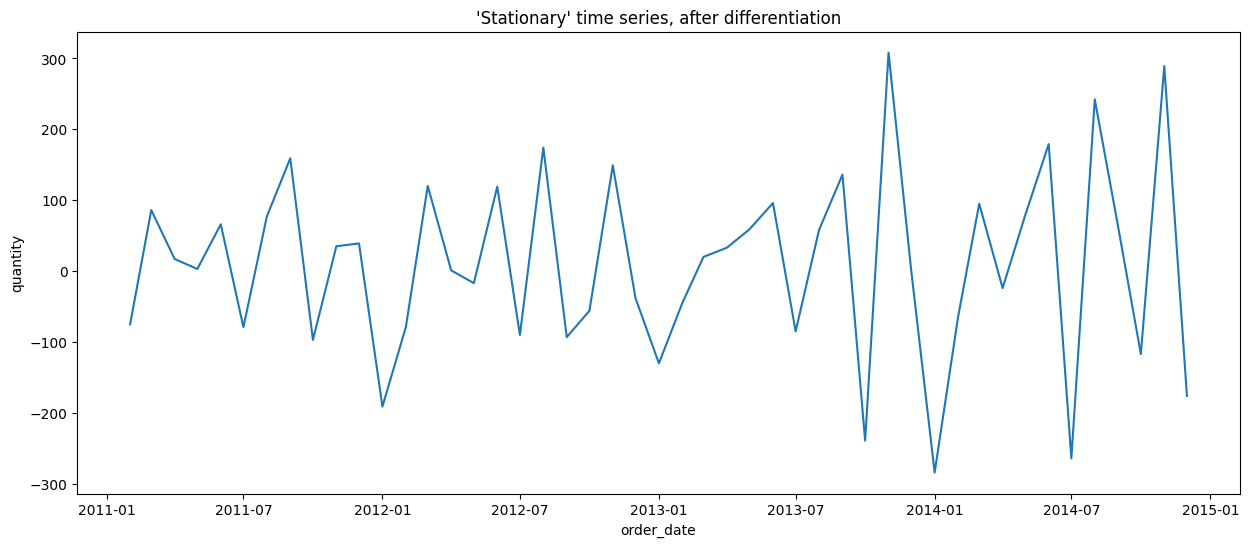

In [94]:
plt.figure(figsize=(15,6))
plt.title("'Stationary' time series, after differentiation")
sns.lineplot(data=data_test_diff_1,
             x="order_date",
             y="quantity")
plt.show()

To choose the other two parameters, ***q*** and ***p***, we need to analyse the ACF and PACF plots, respectively, of the differentiated timeseries. However, it is important to first plot both plots for the original time series to observe patterns.

<Figure size 1200x1000 with 0 Axes>

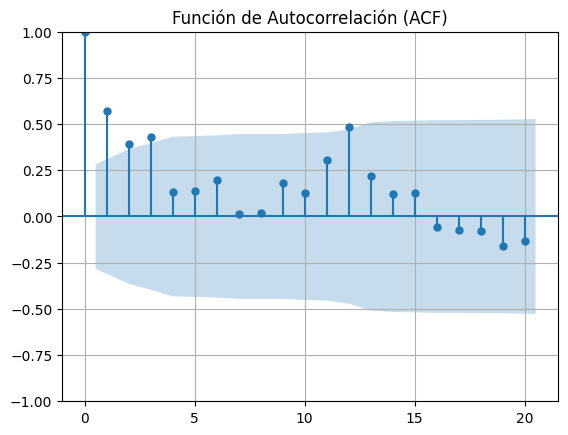

<Figure size 1200x1000 with 0 Axes>

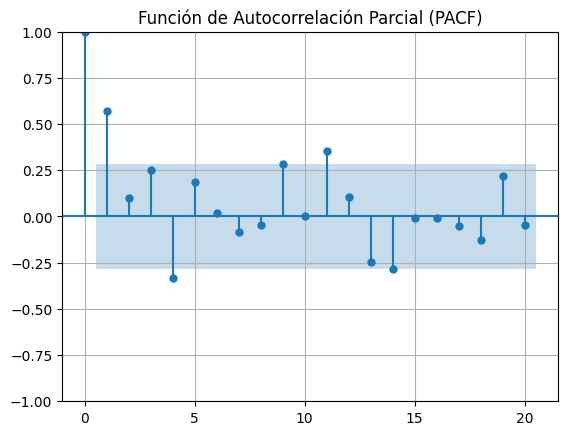

In [95]:
ts_analizer.graficar_acf_pacf(data_test=ts_analizer.data[["quantity"]], lags=20)

In the original ACF, we observe that the autocorrleations fall quickly into the non-significance zone, which means there is not a very strong autocorrelation with past values. There is also a damped sinusoidal yearly wave that almost completely stays within the no-significance zone, which points to a yearly seasonal effect.

Analysing the differentiated ACF and PACF:

<Figure size 1200x1000 with 0 Axes>

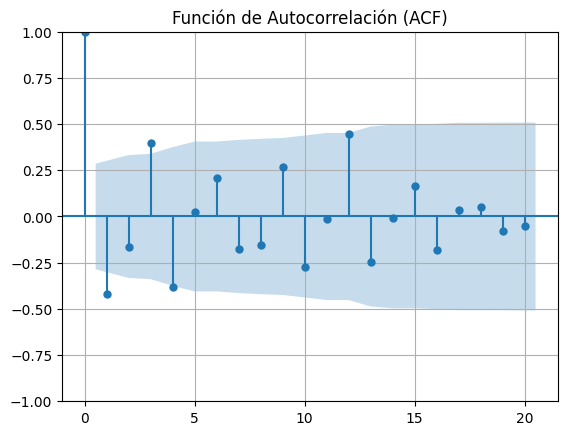

<Figure size 1200x1000 with 0 Axes>

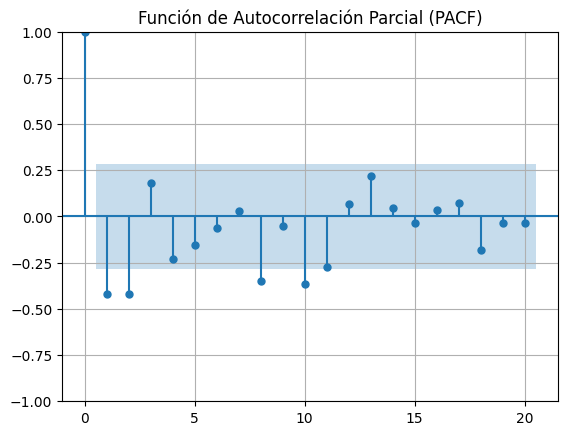

In [96]:
ts_analizer.graficar_acf_pacf(data_test=data_test_diff_1.dropna(), lags=20)

The ACF falls into the no-significance zone after 1 lag, which points to a ***q*** equal to 1. Meanwhile, the PACF falls within no-significance after 2 lags, which points to a ***p*** equal to 2.

Sarima has variations of these 3 parameters (***P***,***D***,***Q***), plus another one that marks the seasonal cycle ***m*** or ***s***. Given that there is a seasonal cycle of 12 periods (a year), ***m*** should equal 12. Then, to uncover the other 3 parameters, an additional differentiation to the differentiated time series should be applied, however, the time series is already stationary and additional differentiations at the seasonal cycle level are not needed. 

Test estacionariedad
-------------------------------------
ADF Statistic: -1.5155198219164259, p-value: 0.5258204126456122


<Figure size 1200x1000 with 0 Axes>

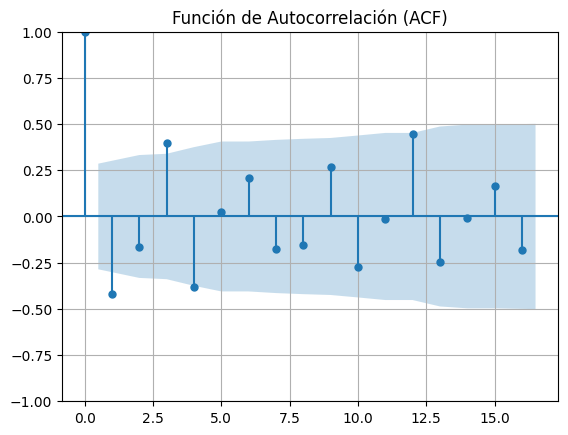

<Figure size 1200x1000 with 0 Axes>

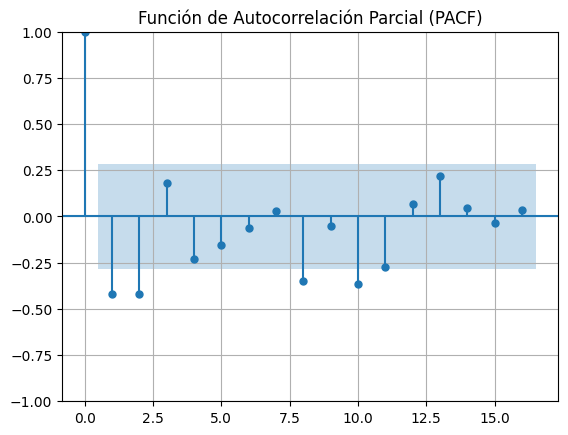

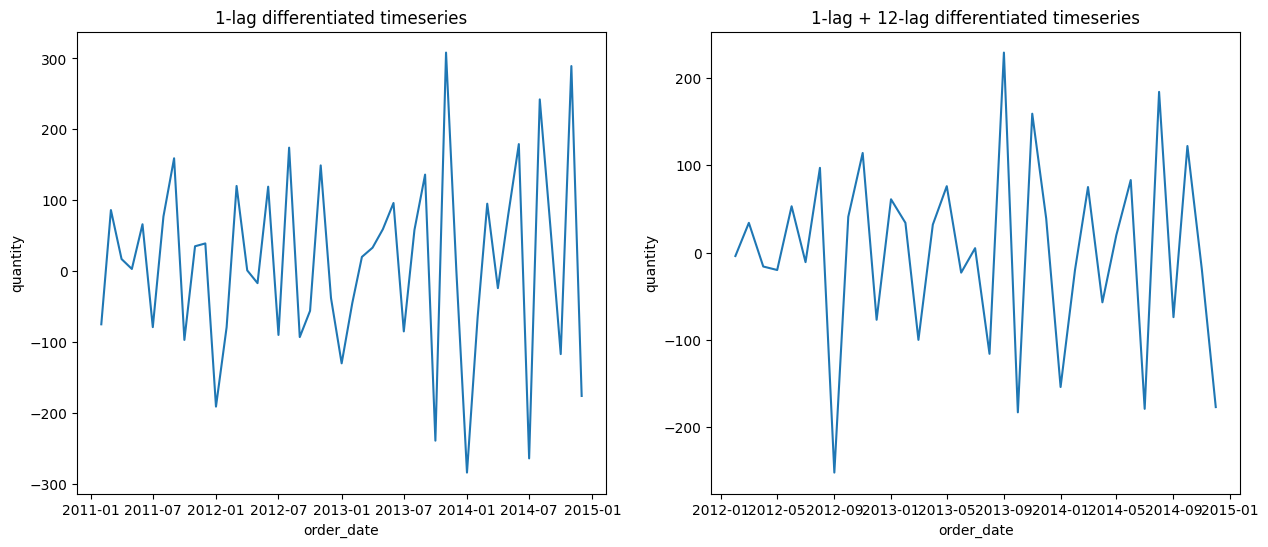

In [99]:
# differentiate the stationarized time series by 12 lags.
data_test_diff_1_12 = data_test_diff_1.diff(12).dropna()

# perform stationary hypothesis test
ts_analizer.prueba_estacionariedad(data_test_diff_1_12)

# plot ACF and PACF
ts_analizer.graficar_acf_pacf(data_test=data_test_diff_1, lags=16)


# Plot both time series
fig, axes = plt.subplots(1,2,figsize=(15,6))

axes[0].set_title("1-lag differentiated timeseries")
sns.lineplot(
    data=data_test_diff_1,
    x="order_date",
    y="quantity",
    ax=axes[0]
)

axes[1].set_title("1-lag + 12-lag differentiated timeseries")
sns.lineplot(
    data=data_test_diff_1_12,
    x="order_date",
    y="quantity",
    ax=axes[1]
)

plt.show()


The ACF, inspected for lags at the seasonal level (12,24), does not show a significant lag at 12, therefore ***Q*** = 0 lags. The PACF does not show cyclical significance either. Nevertheless, a 'Grid Search' of parameters will be performed to validate the least error-prone model configuration.

100%|██████████| 405/405 [00:21<00:00, 19.20it/s]


Mejor modelo encontrado: 1 0 (0, 1, 2, 12)


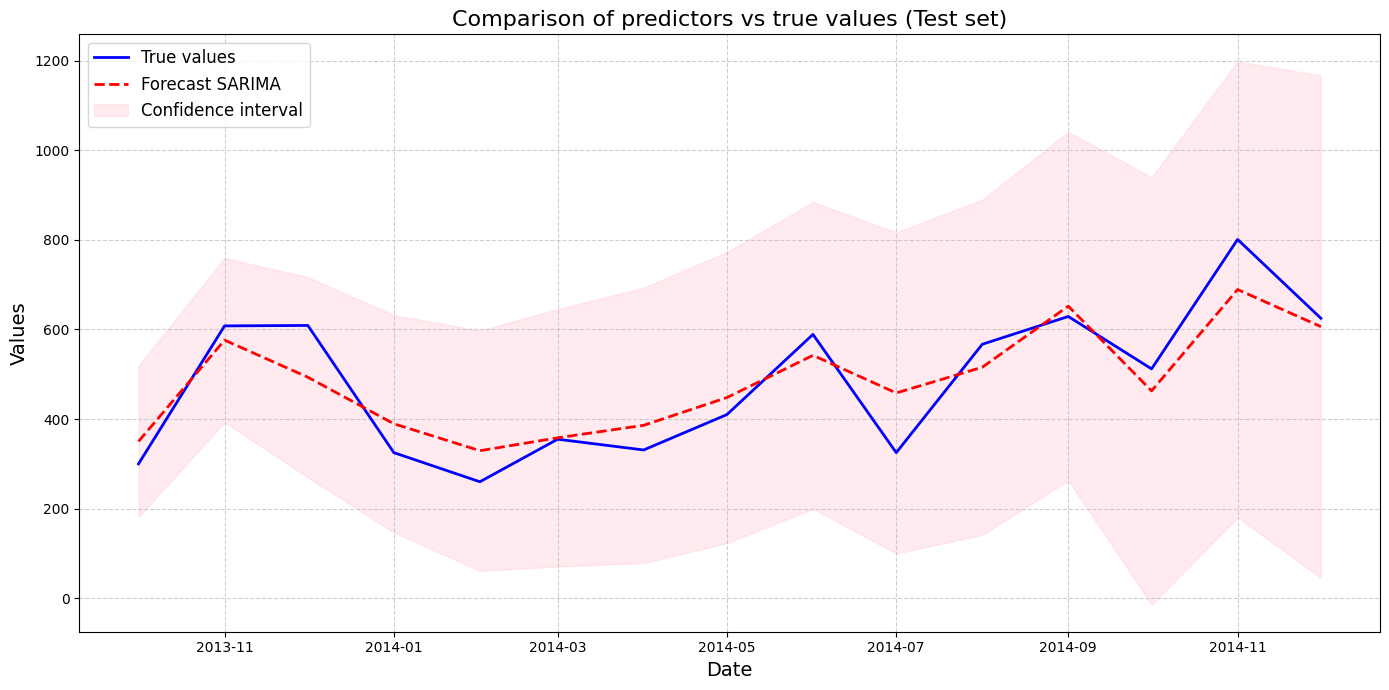

In [100]:
# Setting the target variable and performing train-test split
y = ts_analizer.data[["quantity"]].astype("float").asfreq('MS')
train_size = int(0.7 * len(y))
y_train, y_test = y[:train_size], y[train_size:]

# setting the parameter combinations for the parameter grid search
p_range = range(0,5)
q_range = range(0,3)
seasonal_order_ranges = (range(0,3),range(0,3),range(0,3),[12])

# train and evaluate parameter combinations
warnings.filterwarnings("ignore") # filter out warnings
modelador = ss.SARIMAModel()
parametros = modelador.generar_parametros(p_range, q_range, seasonal_order_ranges)
resultados = modelador.evaluar_modelos_par(y_train, y_test, parametros, 1, len(y), "quantity")
warnings.filterwarnings("default") # bring back warnings

Plotting the test predictions now in context with the train set:

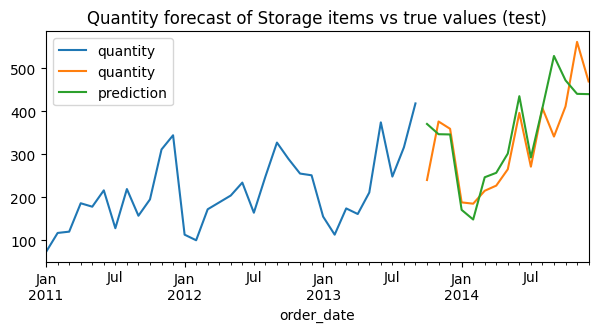

p  q seasonal_order       RMSE
127  1  1  (2, 0, 1, 12)  72.590674
46   0  1  (2, 0, 1, 12)  74.466676
49   0  1  (2, 1, 1, 12)  74.675397
48   0  1  (2, 1, 0, 12)  74.675397
41   0  1  (1, 1, 2, 12)  74.675436
50   0  1  (2, 1, 2, 12)  74.675436
32   0  1  (0, 1, 2, 12)  74.675436
228  2  2  (1, 1, 0, 12)  74.841355
273  3  1  (0, 1, 0, 12)  74.904462
126  1  1  (2, 0, 0, 12)  75.032925

In [166]:
y_pred_test = pd.Series(modelador.best_model["pred_test"], index=y_test.index)

# plot
fig, ax=plt.subplots(figsize=(7, 3))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred_test.plot(ax=ax, label='prediction')
ax.set_title('Quantity forecast of Storage items vs true values (test)')
ax.legend()
plt.show()

# display top 3 parameter settings:

resultados[["p","q","seasonal_order","RMSE"]].sort_values(by="RMSE").head(10)

Huge RMSEs are found with respect to the test set, which could be caused by the huge under and over predictions of EoY.

Many different models provide the same results. That can be due to the fact that there are very few periods to use for seasonal forecasting. As we can see, the predictions do not completely adjust to the fluctuations in price, which are also due to residuals that cannot be controlled.

### 2.3.4 Storage forecasting

Now, it is time to provide the forecast for Storage subcategory demand.

In [114]:
best_model_params = modelador.best_model

modelo_sarima_full = SARIMAX(
    y,
    order=(1, 1, 0),
    seasonal_order=(0,1,2,12),
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

# Forecast 12 months ahead
forecast_start = len(y)
forecast_end = forecast_start + 11
forecast_dates = pd.date_range(
    start=y.index[-1] + pd.offsets.DateOffset(months=1),
    periods=12,
    freq='MS'
)
forecast = modelo_sarima_full.predict(start=forecast_start, end=forecast_end)
forecast = pd.Series(forecast.values, index=forecast_dates)

c:\Users\Miguel\.virtualenvs\9._Clustering_-_Regresión-T2F1V_og\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Plotting the demand forecasted for the upcoming 12 months:

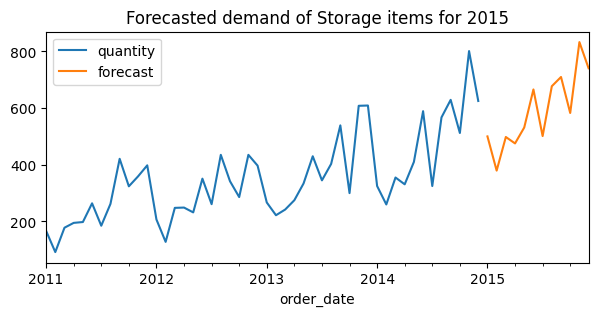

In [115]:
fig, ax=plt.subplots(figsize=(7, 3))
y.plot(ax=ax, label='time series')
forecast.plot(ax=ax, label='forecast')
ax.set_title('Forecasted demand of Storage items for 2015')
ax.legend()
plt.show()

### 2.3.5 Comments about the forecast

The provided forecast tries to give an approximated view of what the demand will be for a set of products in the upcoming year. However, as new data is received from the past months demand, it is recommended to refit the model to obtain more accurate short-term forecasts.

## 2.4 Forecasting demand - Phones

### 2.4.1 Generate phone quantity time series

Filter by Phone sub-category.

In [119]:
global_superstore_phones = global_superstore[global_superstore["sub-category"]=="Phones"]
global_superstore_phones.head(2)

row_id         order_id order_date  ship_date    ship_mode customer_id  \
2  25330    IN-2013-71249 2013-10-17 2013-10-17  First Class    CR-12730   
3  13524  ES-2013-1579342 2013-01-28 2013-01-28  First Class    KM-16375   

      customer_name      segment market product_id    category sub-category  \
2      Craig Reiter     Consumer   APAC       PR-2  Technology       Phones   
3  Katherine Murray  Home Office     EU       PR-3  Technology       Phones   

                        product_name     sales quantity  discount   profit  \
2  Nokia Smart Phone, with Caller ID  5175.171        9       0.1  919.971   
3     Motorola Smart Phone, Cordless  2892.510        5       0.1  -96.540   

   shipping_cost order_priority customer_cluster  
2         915.49         Medium                0  
3         910.16         Medium                2

Resample to monthly data by aggregating quantity sums per month.

In [120]:
# Resample to monthly
global_superstore_phones_resampled = (global_superstore_phones
                                                .set_index("order_date")[["quantity"]]
                                                .resample("MS").sum()).reset_index()

# Generate month and year columns
global_superstore_phones_resampled["year"] = global_superstore_phones_resampled["order_date"].dt.year
global_superstore_phones_resampled["month"] = global_superstore_phones_resampled["order_date"].dt.month_name()
global_superstore_phones_resampled.head(5)

order_date quantity  year     month
0 2011-01-01       73  2011   January
1 2011-02-01      117  2011  February
2 2011-03-01      120  2011     March
3 2011-04-01      186  2011     April
4 2011-05-01      178  2011       May

### 2.4.2 Time series analysis

Let's start by checking for missing values, duplicates and ranges.

In [121]:
ts_analizer = ss.TimeSeriesAnalysis(global_superstore_phones_resampled, temporal_column="order_date",value_column="quantity")

ts_analizer.exploracion_datos()

El número de filas es 48 y el número de columnas es 3

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


count    mean       std     min      25%     50%      75%     max
year   48.0  2012.5  1.129865  2011.0  2011.75  2012.5  2013.25  2014.0

Ensure there are no time gaps in the time series 'quantity' measure.

In [122]:
ts_analizer.comprobar_serie_continua(frecuencia="MS",periodo="M")

La serie temporal es continua, no faltan meses.


Plot the whole time series.

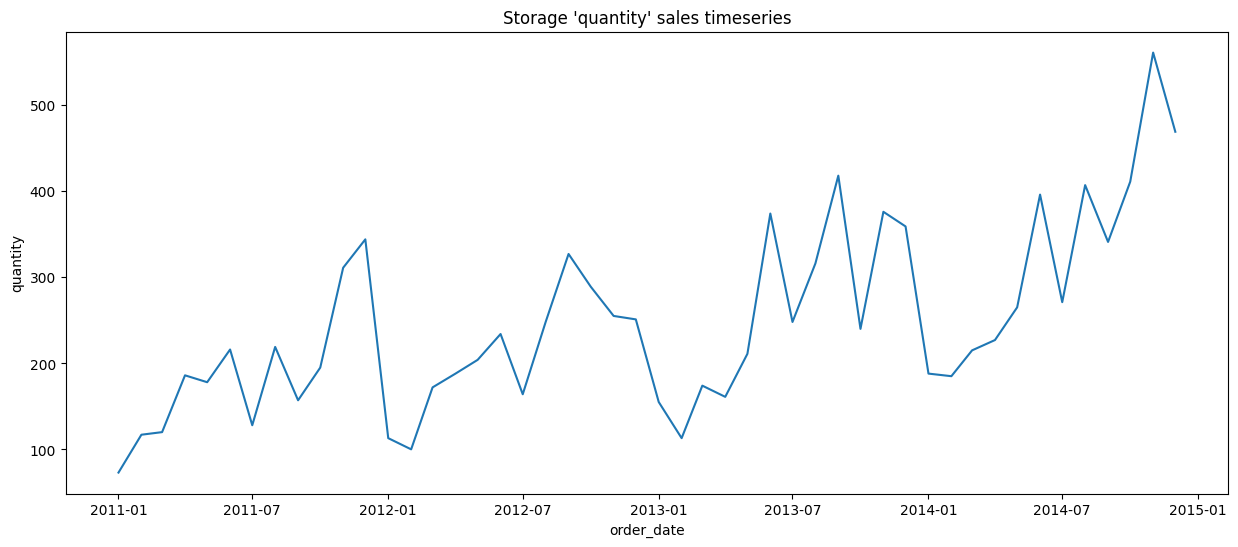

In [124]:
plt.figure(figsize=(15,6))
plt.title("Storage 'quantity' sales timeseries")
sns.lineplot(data=ts_analizer.data,
             x="order_date",
             y="quantity")
plt.show()

Judging from just the timeseries, there is a very obvious upward trend. Some seasonal spikes and valleys are observed, in what look like a fairly yearly seasonal pattern underneath the trend. 

Let's plot the year time series, hued by year.

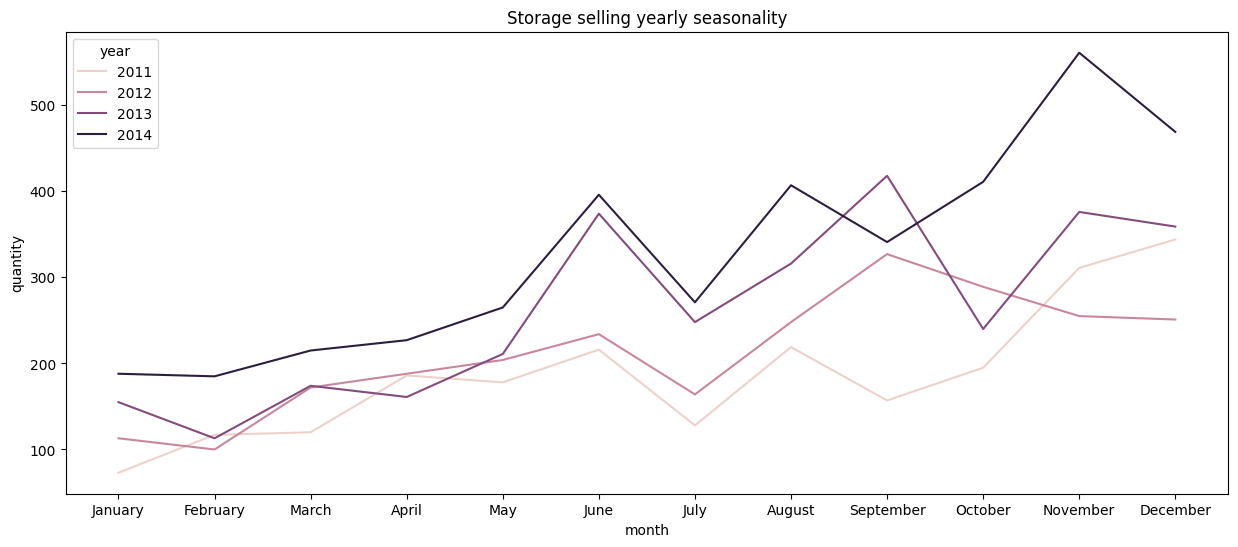

In [125]:
plt.figure(figsize=(15,6))
plt.title("Storage selling yearly seasonality")
sns.lineplot(data=ts_analizer.data,
             x="month",
             y="quantity",
             hue="year")
plt.show()

For this time series, seasonality is not that clear. Seasonal patterns seen at the beginning of the year for previous time series are blurred for this one. The spike and bottom hit in June and July are still present, but at varying strengths, to then be blurred again for September and October.

Let's decompose the time series to observe trend, the automatically captured seasonality and noise.

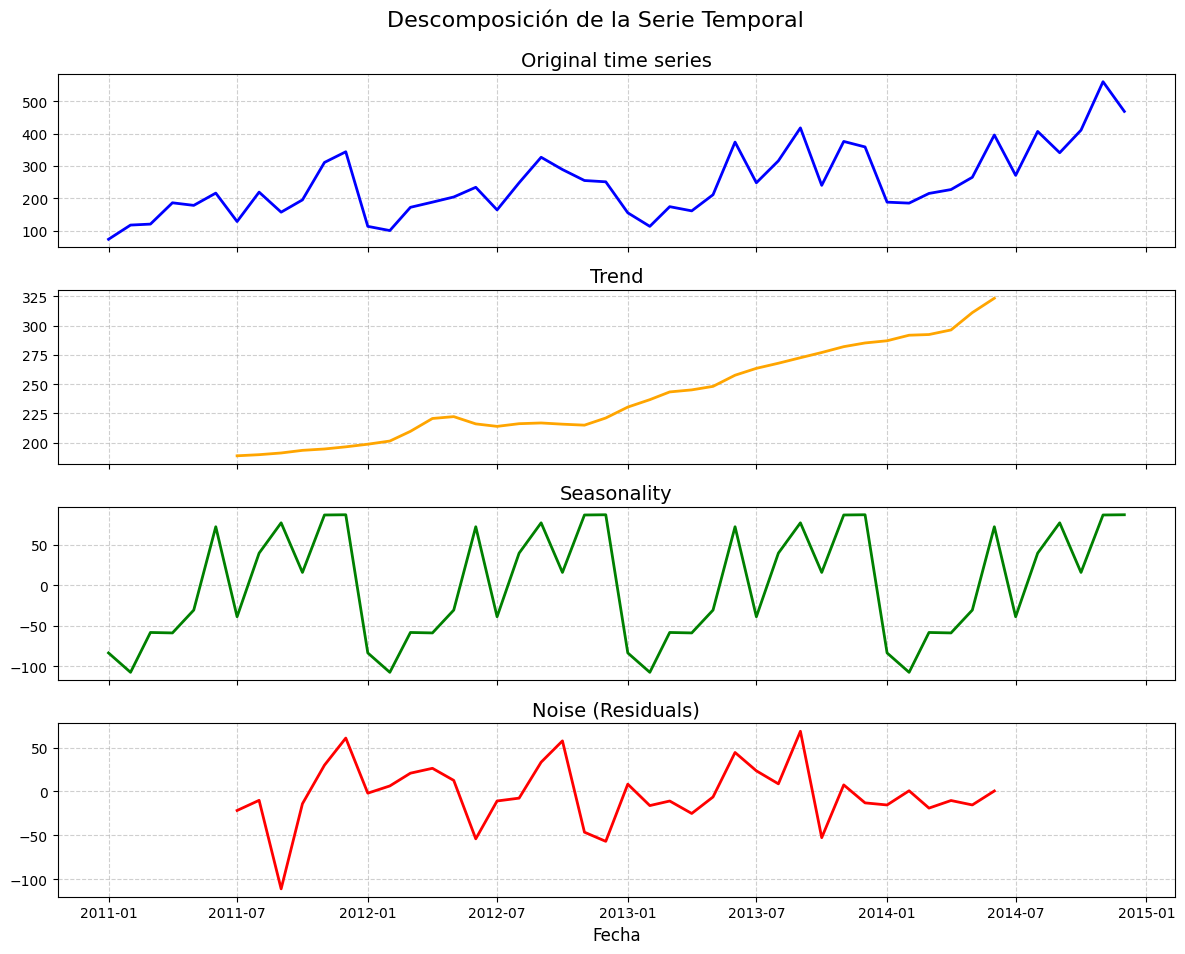

In [126]:
ts_analizer.detectar_estacionalidad()

The biggest actor is the trend.

Noise has a big effect, whcih is on par with seasonality. A Sarima model will be used as it can serve to reduce error and seasonality, if unaccounted, could theoretically double the error.

### 2.4.3 Choose SARIMA parameters

The chosen model to tackle this time series forecasting is a Sarima model. This model takes in the necessary parameters p,d,q. d stands for differentiation and to choose it, it is necessary to apply a differentiation to the time series until it becomes stationary.

In [127]:
ts_analizer.prueba_estacionariedad(ts_analizer.data[["quantity"]])

data_test_diff_1 = ts_analizer.data[["quantity"]].diff().dropna()
ts_analizer.prueba_estacionariedad(data_test_diff_1)

Test estacionariedad
-------------------------------------
ADF Statistic: -3.0375258753029266, p-value: 0.03153547955186482
Test estacionariedad
-------------------------------------
ADF Statistic: -5.528689954401374, p-value: 1.8081113439473086e-06


Data is considered stationary right away. Hoever, after 1 differentiation, it is clear at higher level of significance, thus ***d*** should be equals to 1. Plotting the differentiated time series:

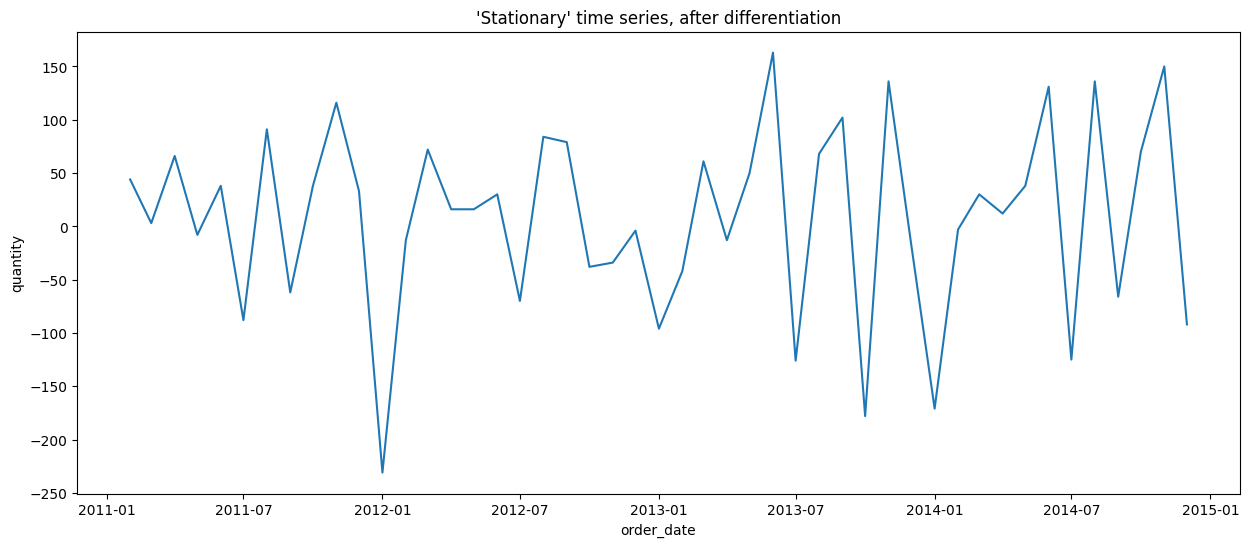

In [128]:
plt.figure(figsize=(15,6))
plt.title("'Stationary' time series, after differentiation")
sns.lineplot(data=data_test_diff_1,
             x="order_date",
             y="quantity")
plt.show()

To choose the other two parameters, ***q*** and ***p***, we need to analyse the ACF and PACF plots, respectively, of the differentiated timeseries. However, it is important to first plot both plots for the original time series to observe patterns.

<Figure size 1200x1000 with 0 Axes>

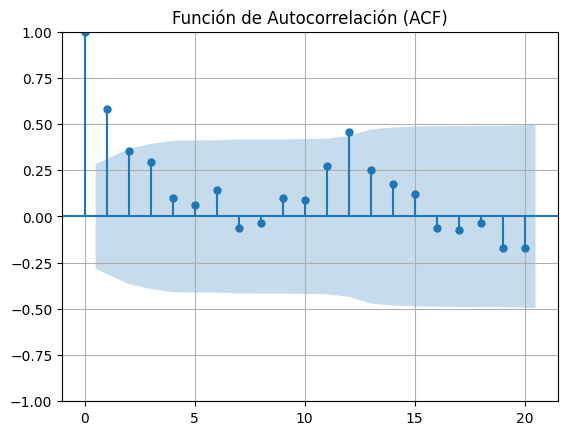

<Figure size 1200x1000 with 0 Axes>

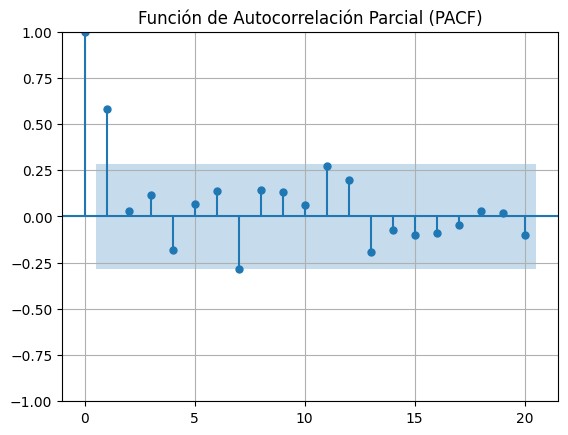

In [129]:
ts_analizer.graficar_acf_pacf(data_test=ts_analizer.data[["quantity"]], lags=20)

In the original ACF, we observe that the autocorrleations fall quickly into the non-significance zone, which means there is not a very strong autocorrelation with past values. There is also a damped sinusoidal yearly wave that almost completely stays within the no-significance zone, which points to a yearly seasonal effect.

Analysing the differentiated ACF and PACF:

<Figure size 1200x1000 with 0 Axes>

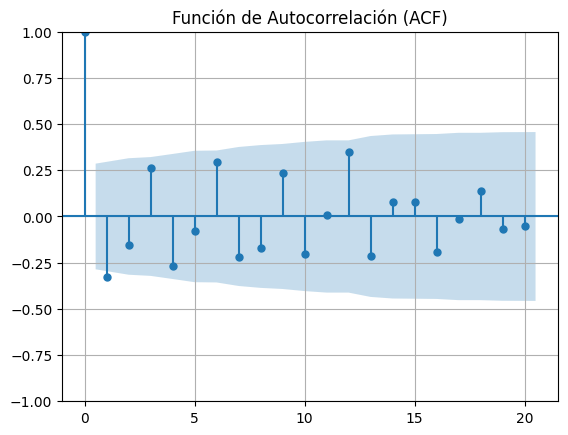

<Figure size 1200x1000 with 0 Axes>

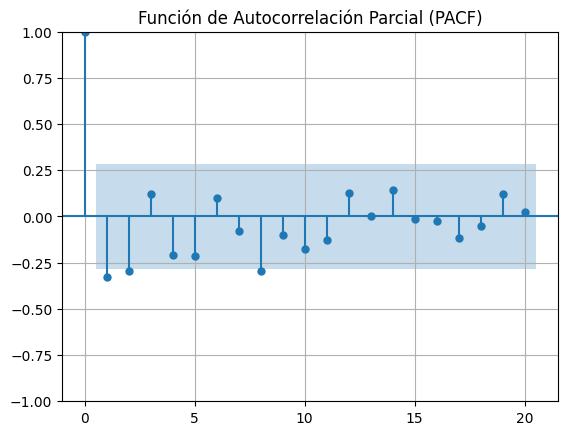

In [130]:
ts_analizer.graficar_acf_pacf(data_test=data_test_diff_1.dropna(), lags=20)

The ACF falls into the no-significance zone after 1 lag, which points to a ***q*** equal to 1. Meanwhile, the PACF falls within no-significance after 2 lags, which points to a ***p*** equal to 2.

Sarima has variations of these 3 parameters (***P***,***D***,***Q***), plus another one that marks the seasonal cycle ***m*** or ***s***. Given that there is a seasonal cycle of 12 periods (a year), ***m*** should equal 12. Then, to uncover the other 3 parameters, an additional differentiation to the differentiated time series should be applied, however, the time series is already stationary and additional differentiations at the seasonal cycle level are not needed. 

Test estacionariedad
-------------------------------------
ADF Statistic: -6.853078897383422, p-value: 1.674917866237871e-09


<Figure size 1200x1000 with 0 Axes>

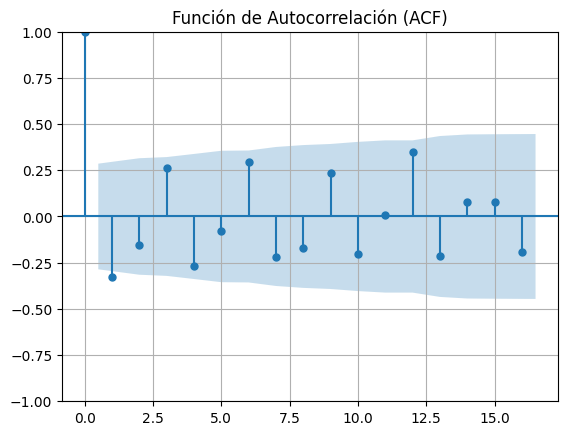

<Figure size 1200x1000 with 0 Axes>

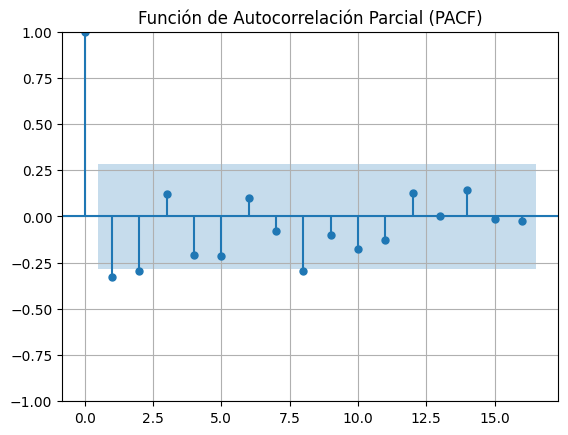

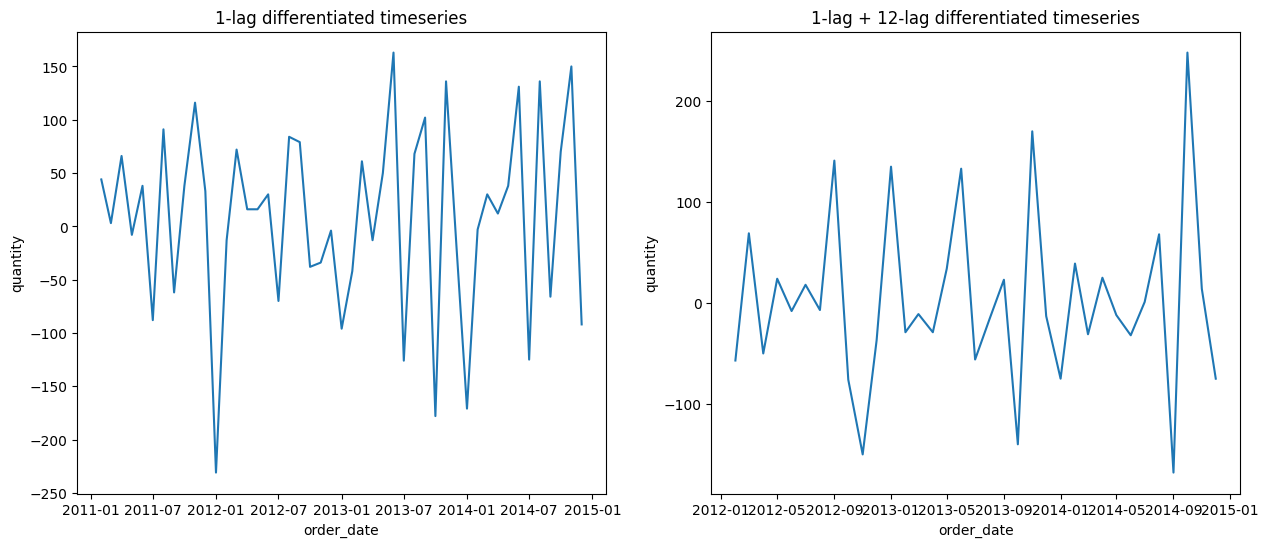

In [131]:
# differentiate the stationarized time series by 12 lags.
data_test_diff_1_12 = data_test_diff_1.diff(12).dropna()

# perform stationary hypothesis test
ts_analizer.prueba_estacionariedad(data_test_diff_1_12)

# plot ACF and PACF
ts_analizer.graficar_acf_pacf(data_test=data_test_diff_1, lags=16)


# Plot both time series
fig, axes = plt.subplots(1,2,figsize=(15,6))

axes[0].set_title("1-lag differentiated timeseries")
sns.lineplot(
    data=data_test_diff_1,
    x="order_date",
    y="quantity",
    ax=axes[0]
)

axes[1].set_title("1-lag + 12-lag differentiated timeseries")
sns.lineplot(
    data=data_test_diff_1_12,
    x="order_date",
    y="quantity",
    ax=axes[1]
)

plt.show()


The ACF, inspected for lags at the seasonal level (12,24), does not show a significant lag at 12, therefore ***Q*** = 0 lags. The PACF does not show cyclical significance either. Nevertheless, a 'Grid Search' of parameters will be performed to validate the least error-prone model configuration.

100%|██████████| 405/405 [00:22<00:00, 17.63it/s]


Mejor modelo encontrado: 1 1 (2, 0, 1, 12)


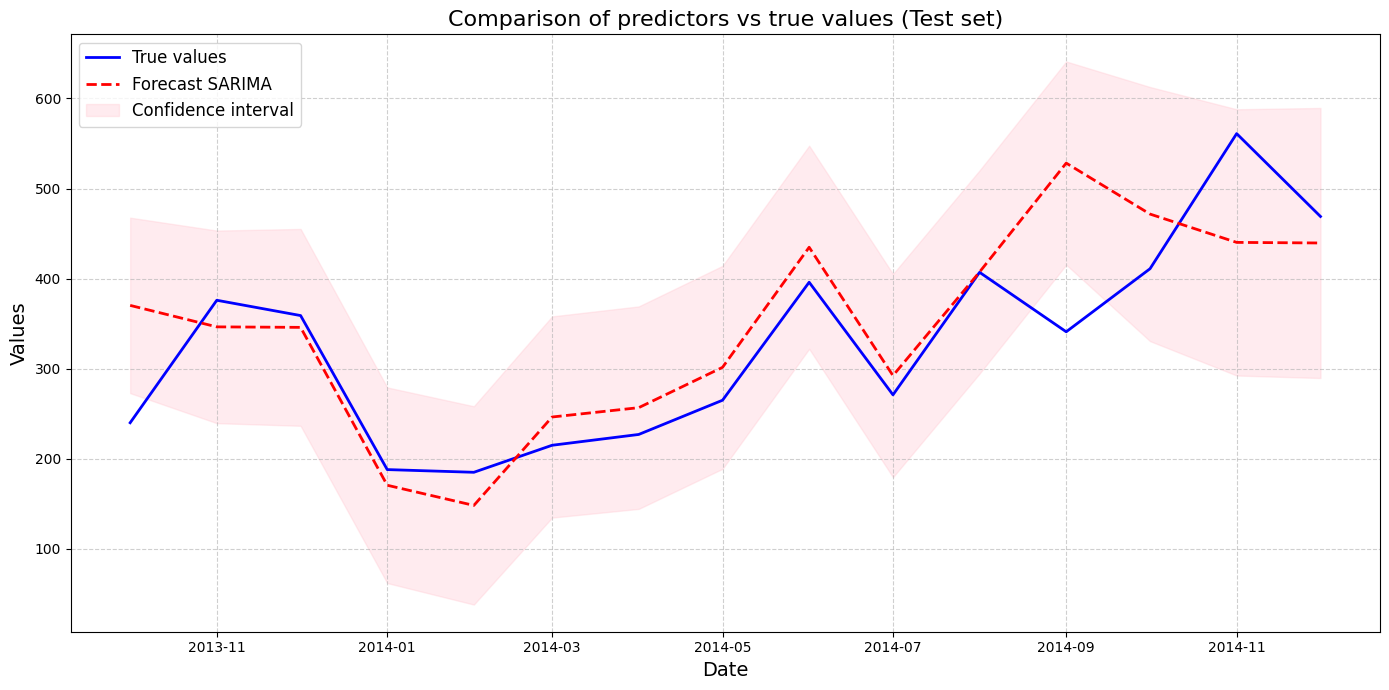

In [132]:
# Setting the target variable and performing train-test split
y = ts_analizer.data[["quantity"]].astype("float").asfreq('MS')
train_size = int(0.7 * len(y))
y_train, y_test = y[:train_size], y[train_size:]

# setting the parameter combinations for the parameter grid search
p_range = range(0,5)
q_range = range(0,3)
seasonal_order_ranges = (range(0,3),range(0,3),range(0,3),[12])

# train and evaluate parameter combinations
warnings.filterwarnings("ignore") # filter out warnings
modelador = ss.SARIMAModel()
parametros = modelador.generar_parametros(p_range, q_range, seasonal_order_ranges)
resultados = modelador.evaluar_modelos_par(y_train, y_test, parametros, 1, len(y), "quantity")
warnings.filterwarnings("default") # bring back warnings

Plotting the test predictions now in context with the train set:

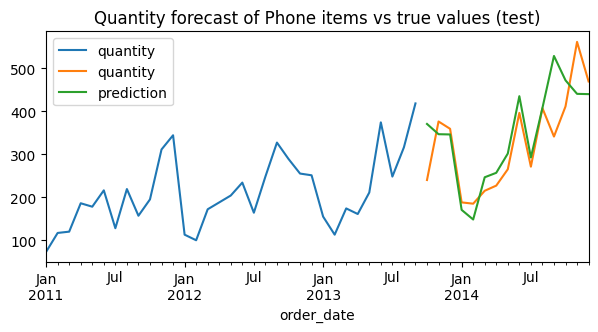

p  q seasonal_order       RMSE
127  1  1  (2, 0, 1, 12)  72.590674
46   0  1  (2, 0, 1, 12)  74.466676
49   0  1  (2, 1, 1, 12)  74.675397
48   0  1  (2, 1, 0, 12)  74.675397
41   0  1  (1, 1, 2, 12)  74.675436

In [136]:
y_pred_test = pd.Series(modelador.best_model["pred_test"], index=y_test.index)

# plot
fig, ax=plt.subplots(figsize=(7, 3))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred_test.plot(ax=ax, label='prediction')
ax.set_title('Quantity forecast of Phone items vs true values (test)')
ax.legend()
plt.show()

# display top 3 parameter settings:

resultados[["p","q","seasonal_order","RMSE"]].sort_values(by="RMSE").head(5)

Many different models provide the same results. That can be due to the fact that there are very few periods to use for seasonal forecasting. As we can see, the predictions do not completely adjust to the fluctuations in price, which are also due to residuals that cannot be controlled.

### 2.4.4 Phone forecasting

Now, it is time to provide the forecast for Storage subcategory demand.

In [164]:
best_model_params = modelador.best_model

modelo_sarima_full = SARIMAX(
    y,
    order=(0, 1, 1),
    seasonal_order=(1,1,2,12),
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit(disp=False)

# Forecast 12 months ahead
forecast_start = len(y)
forecast_end = forecast_start + 11
forecast_dates = pd.date_range(
    start=y.index[-1] + pd.offsets.DateOffset(months=1),
    periods=12,
    freq='MS'
)
forecast = modelo_sarima_full.predict(start=forecast_start, end=forecast_end)
forecast = pd.Series(forecast.values, index=forecast_dates)

c:\Users\Miguel\.virtualenvs\9._Clustering_-_Regresión-T2F1V_og\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Plotting the demand forecasted for the upcoming 12 months:

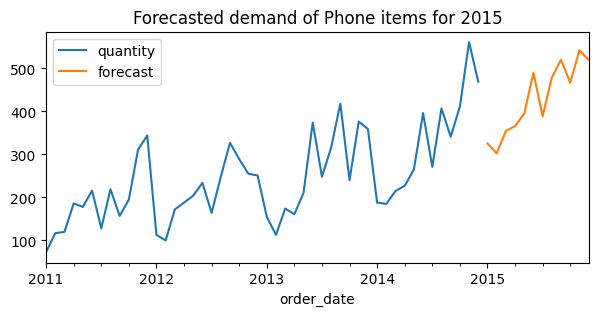

In [165]:
fig, ax=plt.subplots(figsize=(7, 3))
y.plot(ax=ax, label='time series')
forecast.plot(ax=ax, label='forecast')
ax.set_title('Forecasted demand of Phone items for 2015')
ax.legend()
plt.show()

### 2.4.5 Comments about the forecast

The provided forecast tries to give an approximated view of what the demand will be for a set of products in the upcoming year. However, as new data is received from the past months demand, it is recommended to refit the model to obtain more accurate short-term forecasts.